In [1]:
#imports
import gzip
import pandas as pd
import os
from collections import defaultdict
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import ast
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
#import functions from analysis_functions.py
#reinport the functions from the analysis_functions.py file
import importlib
import analysis_functions as af
importlib.reload(af)

2025-04-18 23:51:01 - RepertoireReader - INFO - Logging initialized
2025-04-18 23:51:01 - faiss.loader - INFO - Loading faiss with AVX2 support.
2025-04-18 23:51:01 - faiss.loader - INFO - Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2025-04-18 23:51:01 - faiss.loader - INFO - Loading faiss.
2025-04-18 23:51:01 - faiss.loader - INFO - Successfully loaded faiss.
c:\Users\fried\miniconda3\envs\env\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


<module 'analysis_functions' from 'c:\\Users\\fried\\Desktop\\Project_emerson\\analysis_functions.py'>

In [3]:
#define path
path = os.getcwd()
print(path)

c:\Users\fried\Desktop\Project_emerson


# Functions 

### 1. Match patients with TCRs
##### Read all the patient files and make a dictionary where key = combination, value = list of reperoire_ids

In [2]:
## execute the function
tcr_df = af.matching_patients_tcrs('\\data\\HLA_emerson_2017')


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [8]:
#write_to_file(tcr_df, 'results\\tcr_df_output.tsv')
tcr_df = af.read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

In [9]:
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV5-1', 'CASSLRGSGNTIYF', 'TRBJ1-3')","{P00387_clonotypes, P00007_clonotypes, P00354_..."
1,"('TRBV4-2', 'CASSQEGQSSYEQYF', 'TRBJ2-7')","{P00317_clonotypes, P00111_clonotypes, P00118_..."
2,"('TRBV6-5', 'CASSYSGSNQPQHF', 'TRBJ1-5')","{P00214_clonotypes, P00251_clonotypes, P00168_..."
3,"('TRBV6-5', 'CASSYYGTAQETQYF', 'TRBJ2-5')","{P00329_clonotypes, P00115_clonotypes, P00001_..."
4,"('TRBV6-4', 'CASSDNSGANVLTF', 'TRBJ2-6')","{P00052_clonotypes, P00214_clonotypes, P00251_..."


### 2. Match HLA-labelling of patients
##### Match the HLA-labelling with the patient files (A_02_01_features.txt contains the indices to the patient files)


In [10]:
patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df)

patient_df.head()

,repertoire_id,has_HLA_A02_01
0,P00001_clonotypes,False
1,P00002_clonotypes,True
2,P00003_clonotypes,True
3,P00004_clonotypes,True
4,P00005_clonotypes,False


### 3. Fisher-exact method
#####  Make a dataframe where every row contains the TCR (combination), the p-value and odds ratio of fisher_exact method (use psuedocount of 0.1)

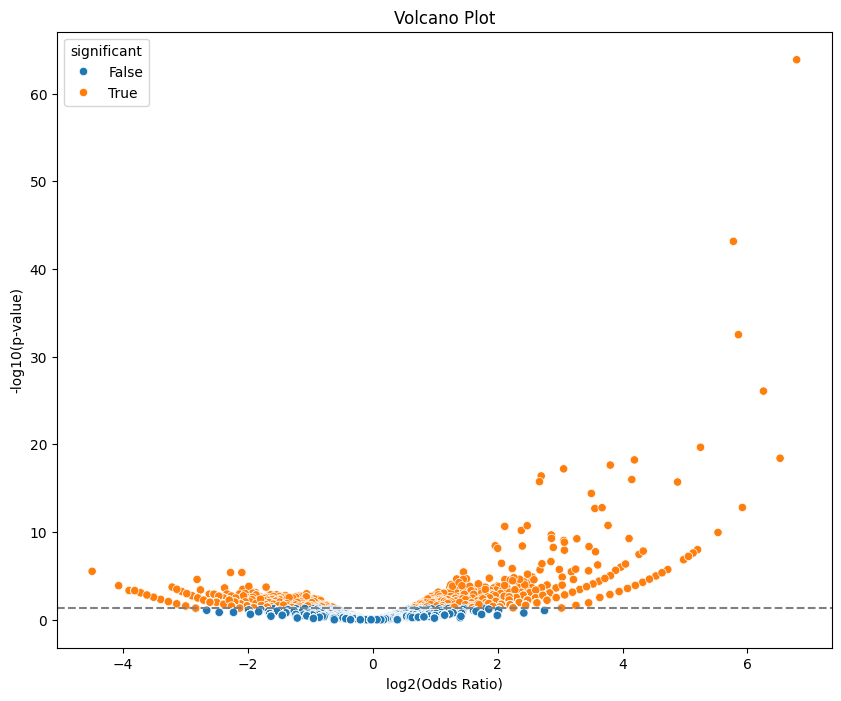

In [ ]:
patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df, 400)
fisher_exact_results_df = af.execute_fisher_exact(tcr_df, patient_df)
af.write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results.tsv')

af.generate_volcano_plot(fisher_exact_results_df, 'results\\plots\\volcano_plot.png')

### 4. Train classifier model
#####  match/count the HLA-02.01 related TCR's for every patient
##### make a table with 3 columns: patient, #total TCR's and #HLA-02.01 related TCR's (from the fisher_exact_results_df where p-value < 0.05 and odds_ratio > 1)

In [56]:

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df)

fisher_exact_results_df = af.read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)

result_df = af.match_and_select_related_tcrs(fisher_exact_results_df, patient_df, '\\data\\HLA_emerson_2017', top_n=20000)



Related TCRs fisher exact:  21989
Selected related TCRs:  20000


In [57]:
result_df.head()

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,P00001_clonotypes,80376,150,False
1,P00002_clonotypes,72026,524,True
2,P00003_clonotypes,125428,1075,True
3,P00004_clonotypes,147857,1141,True
4,P00005_clonotypes,76068,120,False


### 5. Select different top related TRCs, train the model and calculate metrics
##### Make a table with the different metrics (AUC, sensitivity, specificity, accuracy) and different top related TCRs
##### Apply Benjamini-Hochberg correction
##### Select top n related TCRs based on p-value

In [45]:
top_n = [5, 10, 20, 30, 50, 90, 100, 500, 1000, 5000, 10000, 20000]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df)

fisher_exact_results_df = af.read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
patients_path = '\\data\\HLA_emerson_2017'

BN = [False]

for bn in BN:
# Filter the top_n list dynamically
    if bn:
        top_n = [n for n in top_n if n <= 90]  # Use only smaller values for BH correction

    for n in top_n:
        #result_df_training_plot = result_df_copy.iloc[:400]
        #af.plot_total_vs_significant_tcrs(result_df_training_plot, n)
        result_df = af.preprocessing_dataset(fisher_exact_results_df, patient_df, patients_path, top_n=n, benjamini_hochberg=bn)
        model, metrics_training = af.train_training_dataset(result_df, top_n=n, benjamini_hochberg=bn)
        metrics_training_data.append(metrics_training)

        #validation set
        metrics_validation = af.validate_validation_dataset(result_df, top_n=n, number_patients=400,
                                                            benjamini_hochberg=bn, model=model)
        metrics_validation_data.append(metrics_validation)

    
metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\metrics_classifiers_training.tsv')
af.write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation.tsv')

metrics_training_df
metrics_validation_df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

[]


In [58]:
metrics_validation_df = af.read_file('results\\metrics_classifiers_validation.tsv')
metrics_validation_df

,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,False,0.488017,0.000000,1.000000,0.580786
1,10,False,0.963503,0.937500,0.977444,0.960699
2,20,False,0.979558,0.927083,0.984962,0.960699
3,30,False,0.990523,0.937500,1.000000,0.973799
4,50,False,0.992716,0.947917,0.984962,0.969432
5,90,False,0.994674,0.947917,0.977444,0.965066
6,100,False,0.997024,0.958333,0.984962,0.973799
7,500,False,0.975956,0.864583,0.984962,0.934498
8,1000,False,0.972118,0.802083,0.992481,0.912664
9,5000,False,0.900454,0.770833,0.857143,0.820961


### 6. Semi-supervised learning
##### semi-supervised learning of self-training, een model wordt gebruikt om labels toe te kennen aan nieuwe data (pseudo-labeling), en deze worden vervolgens toegevoegd aan de trainingsdata voor een nieuwe iteratie van modeltraining.

In [63]:
tcr_df = af.matching_patients_tcrs('\\data\\HLA_Mitchell_Michels_2022')

In [ ]:
af.write_to_file(tcr_df, 'results\\tcr_df_output_Mitchell.tsv')

In [96]:

tcr_df = af.read_file('results\\tcr_df_output_Mitchell.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV7-9', 'CASSLARSTGELFF', 'TRBJ2-2')","{DenverT1D-258_TCRB, Daisy-20_TCRB, DenverT1D-..."
1,"('TRBV7-9', 'CASSLEGTGGAAYGYTF', 'TRBJ1-2')","{DenverT1D-354_TCRB, 310216_TCRB, Daisy-16_TCR..."
2,"('TRBV6-4', 'CASSGENTGELFF', 'TRBJ2-2')","{310126_TCRB, 310216_TCRB, 310221_TCRB, Denver..."
3,"('TRBV28', 'CASSSDRVYGYTF', 'TRBJ1-2')","{DenverT1D-253_TCRB, DenverT1D-243_TCRB, 31028..."
4,"('TRBV6-4', 'CASSLTGTNSPLHF', 'TRBJ1-6')","{DenverT1D-184_TCRB, DenverT1D-095_TCRB, 31021..."


In [119]:

patient_df_mitchel = af.read_patients_hla_labelling_mitchel('\\data\\HLA_Mitchell_Michels_2022.tsv')
patient_df_mitchel


,repertoire_id,has_HLA_A02_01
0,310148_TCRB,False
1,310230_TCRB,False
2,310122_TCRB,True
3,310204_TCRB,True
4,310221_TCRB,False
...,...,...
211,310106_TCRB,False
212,310113_TCRB,True
213,310266_TCRB,True
214,310175_TCRB,False


In [103]:
fisher_exact_results_df = af.execute_fisher_exact(tcr_df, patient_df_mitchel)
af.write_to_file(fisher_exact_results_df, 'results\\fisher_exact_results_Mitchell.tsv')


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [107]:
fisher_exact_results_df_mitchel = af.read_file('results\\fisher_exact_results_Mitchell.tsv')
fisher_exact_results_df_mitchel['TCR'] = fisher_exact_results_df_mitchel['TCR'].apply(ast.literal_eval)

In [120]:
result_df_mitchel = af.match_and_select_related_tcrs(fisher_exact_results_df_mitchel, patient_df_mitchel, '\\data\\HLA_Mitchell_Michels_2022', 100, benjamini_hochberg=False)
len(result_df_mitchel)

359

In [121]:
result_df_mitchel

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,310101_TCRB,12759,2,True
1,310102_TCRB,67451,0,False
2,310103_TCRB,59566,8,True
3,310104_TCRB,108101,15,True
4,310105_TCRB,146091,11,True
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,None
355,DenverT1D-383_TCRB,30351,0,None
356,DenverT1D-384_TCRB,219423,12,None
357,DenverT1D-386_TCRB,188585,17,None


In [122]:
## Read a trained model (Benjamini-Hochberg correction and top 50 related TCRs)
model = load('results\\models\\logistic_regression_top100_related_tcrs.joblib')
X_val = result_df_mitchel[['total_tcrs', 'related_tcrs']]


result_df_mitchel['probability'] = model.predict_proba(X_val)[:, 1]
result_df_mitchel['prediction'] = model.predict(X_val)

In [123]:
result_df_mitchel.head(10)

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01,probability,prediction
0,310101_TCRB,12759,2,True,0.594227,1
1,310102_TCRB,67451,0,False,0.014477,0
2,310103_TCRB,59566,8,True,0.729968,1
3,310104_TCRB,108101,15,True,0.889885,1
4,310105_TCRB,146091,11,True,0.066112,0
5,310106_TCRB,109520,3,False,0.006170,0
6,310108_TCRB,137896,18,True,0.880398,1
7,310109_TCRB,129277,0,False,0.000307,0
8,310110_TCRB,52862,4,True,0.279489,0
9,310111_TCRB,150293,2,False,0.000268,0


In [124]:
#calculate average probability
average_probability = result_df_mitchel['probability'].mean()
average_probability

0.43647820476766774

In [125]:
#calculate median of probability of model
median_probability = result_df_mitchel['probability'].median()
median_probability

0.0770385297166013

In [126]:
train_result_df = result_df_mitchel[['repertoire_id', 'total_tcrs', 'related_tcrs','prediction']]
train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)
train_result_df

C:\Users\fried\AppData\Local\Temp\ipykernel_15252\3173823734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01_label
0,310101_TCRB,12759,2,1
1,310102_TCRB,67451,0,0
2,310103_TCRB,59566,8,1
3,310104_TCRB,108101,15,1
4,310105_TCRB,146091,11,0
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,0
355,DenverT1D-383_TCRB,30351,0,0
356,DenverT1D-384_TCRB,219423,12,0
357,DenverT1D-386_TCRB,188585,17,0


ROC Logistic Regression top 100 related tcrs (Training set)


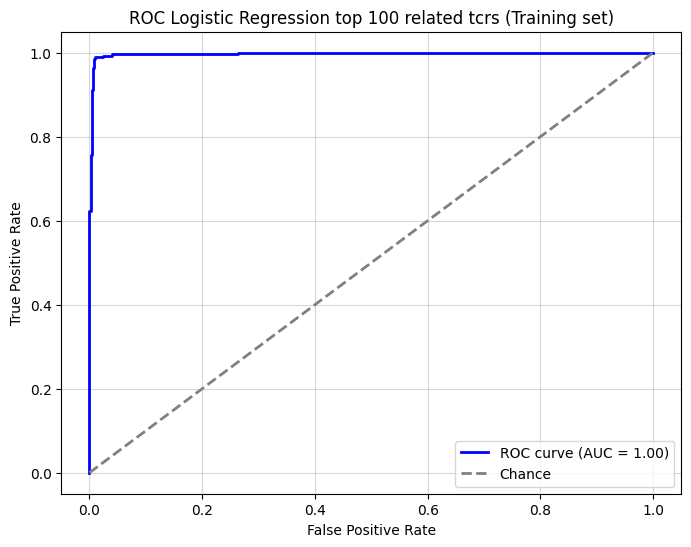

Sensitivity: 0.99
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       475
     Class 1       0.98      0.99      0.99       284

    accuracy                           0.99       759
   macro avg       0.99      0.99      0.99       759
weighted avg       0.99      0.99      0.99       759

ROC Logistic Regression top 100 related tcrs (Validation set)


C:\Users\fried\AppData\Local\Temp\ipykernel_15252\1054395001.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
C:\Users\fried\AppData\Local\Temp\ipykernel_15252\1054395001.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


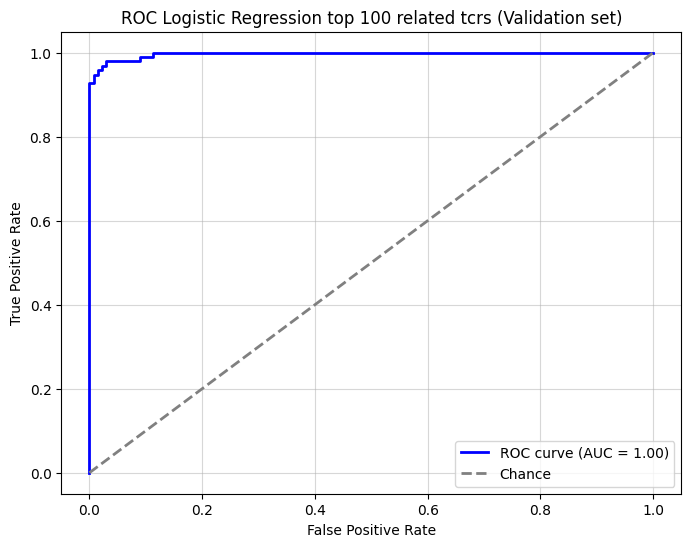

Sensitivity: 0.96
Specificity: 0.98
Accuracy: 0.97
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.98       133
     Class 1       0.98      0.96      0.97        96

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.97      0.97      0.97       229



,top_n,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,False,0.997024,0.958333,0.984962,0.973799


In [127]:
metrics_validation_data = []
metrics_training_data = []

bn = False
n = 100


patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_emerson = af.select_patients_hla_labelling(patient_df)


fisher_exact_results_df_emerson = af.read_file('results\\fisher_exact_results.tsv')
fisher_exact_results_df_emerson['TCR'] = fisher_exact_results_df_emerson['TCR'].apply(ast.literal_eval)

result_df_emerson = af.preprocessing_dataset(fisher_exact_results_df_emerson, patient_df_emerson, '\\data\\HLA_emerson_2017', top_n=n, benjamini_hochberg=bn)

#training set
#select first 400 patients for training
result_df_emerson.sort_values(by=['repertoire_id'], inplace=True, ignore_index=True)
result_df_training = result_df_emerson.iloc[:400]
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())
result_df_training = pd.concat([train_result_df, result_df_training], ignore_index=True)
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())


model, metrics_training = af.train_training_dataset(result_df_training, top_n=n, benjamini_hochberg=bn, semi_supervised=True)
metrics_training_data.append(metrics_training)

#validation set
metrics_validation = af.validate_validation_dataset(result_df_emerson, top_n=n,number_patients=400,
                                                     benjamini_hochberg=bn, model=model,semi_supervised=True)
metrics_validation_data.append(metrics_validation)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_semi_supervised.tsv')
af.write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_semi_supervised.tsv')

metrics_training_df
metrics_validation_df

### 7. Make the training data imbalanced
##### Lower the positive labels for HLA-A (from training data) to find a minimum threshold until where our trained model stays reliable


In [19]:
tcr_df = af.read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

In [34]:
thresholds = [5, 10, 15, 30, 50, 100, 'all']

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df, 400)

for threshold in thresholds:
    patients_df_filtered = af.select_positive_patients(patient_df, threshold)
    print("threshold = " + str(threshold))
    print(patients_df_filtered['has_HLA_A02_01'].value_counts())
    fisher_exact_results_df = af.execute_fisher_exact(tcr_df, patients_df_filtered)
    
    af.write_to_file(fisher_exact_results_df, 'results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')

threshold = 5
has_HLA_A02_01
False    211
True       5
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 10
has_HLA_A02_01
False    211
True      10
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 15
has_HLA_A02_01
False    211
True      15
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 30
has_HLA_A02_01
False    211
True      30
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 50
has_HLA_A02_01
False    211
True      50
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = 100
has_HLA_A02_01
False    211
True     100
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


threshold = None
has_HLA_A02_01
False    211
True     161
Name: count, dtype: int64


c:\Users\fried\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
thresholds = [5, 10, 15, 30, 50, 100]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)

bn = False
n =  100

for threshold in thresholds:
    fisher_exact_results_df = af.read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
    fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
    print("Fisher exact: ", len(fisher_exact_results_df))

    patient_df_training = af.select_patients_hla_labelling(patient_df, 400)
    patients_df_filtered = af.select_positive_patients(patient_df_training, threshold)

    #training set
    filename = 'results\\7\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '.joblib'
    result_df_training = af.preprocessing_dataset(fisher_exact_results_df, patients_df_filtered, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
    model, metrics_training = af.train_training_dataset(result_df_training, top_n=n, benjamini_hochberg=bn, filename_model=filename)
    metrics_training_data.append(metrics_training)

    #validation set
    patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)
    result_df_validation = af.preprocessing_dataset(fisher_exact_results_df, patient_df_validation, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
    
    metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n,
                                                        benjamini_hochberg=bn, model=model)
    metrics_validation_data.append(metrics_validation)
    
        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\7\\metrics_classifiers_training_thresholds.tsv')
af.write_to_file(metrics_validation_df, 'results\\7\\metrics_classifiers_validation_thresholds.tsv')

metrics_training_df
metrics_validation_df

In [59]:
metrics_validation_df = af.read_file('results\\7\\metrics_classifiers_validation_thresholds.tsv')
metrics_validation_df

,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,False,0.611464,0.018692,1.000000,0.591440
1,100,10,False,0.774330,0.121495,1.000000,0.634241
2,100,15,False,0.887414,0.523364,0.993333,0.797665
3,100,30,False,0.962741,0.831776,1.000000,0.929961
4,100,50,False,0.981931,0.719626,1.000000,0.883268
5,100,100,False,0.991776,0.925234,0.993333,0.964981


#### 7.1. Select only top x TCRs in patient files
##### Run matching_patient_tcrs for a specific threshold of top TCRs
##### Execute fisher_exact method for these matching patient tcrs
##### Use the fisher_exact results for training and test data

In [ ]:
selected_tcrs_patients = [25000, 50000]
thresholds = [5, 10, 15, 30, 50, 100, 'all']

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df, 400)

for n in selected_tcrs_patients:
    tcr_df = af.matching_patients_tcrs('\\data\\HLA_emerson_2017', top_n=n)
    af.write_to_file(tcr_df, 'results\\7\\tcr_df_output_selected_' + str(n) + '_tcrs.tsv')

    for threshold in thresholds:
        patients_df_filtered = af.select_positive_patients(patient_df, threshold)
        print("threshold = " + str(threshold))
        print(patients_df_filtered['has_HLA_A02_01'].value_counts())
        fisher_exact_results_df = af.execute_fisher_exact(tcr_df, patients_df_filtered)
        
        af.write_to_file(fisher_exact_results_df, 'results\\7\\fisher_exact_results_threshold_' + str(threshold) + '_selected_' + str(n) + '_tcrs.tsv')

In [ ]:
thresholds = [5, 10, 15, 30, 50, 100, 'all']    
selected_tcrs_patients = [25000, 50000]

metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)
patients_path = '\\data\\HLA_emerson_2017'

bn = False
n =  100
for x in selected_tcrs_patients:
    for threshold in thresholds:
        fisher_exact_results_df = af.read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '_selected_' + str(x) + '_tcrs.tsv')
        fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
        print("Fisher exact: ", len(fisher_exact_results_df))

        #training set
        patient_df_training = af.select_patients_hla_labelling(patient_df, 400)
        patients_df_filtered = af.select_positive_patients(patient_df_training, threshold)
        result_df = af.preprocessing_dataset(fisher_exact_results_df, patients_df_filtered, patients_path, top_n=n, benjamini_hochberg=bn)
        filename = 'results\\7\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '_selected_' + str(x) + '.joblib'
        model, metrics_training = af.train_training_dataset(result_df_training, top_n=n, benjamini_hochberg=bn, 
                                                            threshold=threshold, selected_tcrs_patients=x, filename_model=filename)
        metrics_training_data.append(metrics_training)
        

        #validation set
        patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)
        result_df_validation = af.preprocessing_dataset(fisher_exact_results_df, patient_df_validation, patients_path, top_n=n, benjamini_hochberg=bn)
        
        metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn, model=model, threshold=threshold, selected_tcrs_patients=x)

        print("Validation set: ", len(result_df_validation))

        metrics_validation_data.append(metrics_validation)
    
        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\7\\metrics_classifiers_training_thresholds_selected_tcrs_.tsv')
af.write_to_file(metrics_validation_df, 'results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_.tsv')

metrics_training_df
metrics_validation_df

In [32]:
metrics_training_df

,top_n,threshold,selected_tcrs_per_patient,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,25000,False,1.000000,1.000000,1.000000,1.000000
1,100,10,25000,False,1.000000,1.000000,1.000000,1.000000
2,100,15,25000,False,1.000000,1.000000,1.000000,1.000000
3,100,30,25000,False,0.999368,0.966667,0.995261,0.991701
4,100,50,25000,False,0.999431,0.980000,0.995261,0.992337
5,100,100,25000,False,0.999384,0.990000,0.990521,0.990354
6,100,all,25000,False,0.998469,0.981366,0.981043,0.981183
7,100,5,50000,False,1.000000,1.000000,1.000000,1.000000
8,100,10,50000,False,1.000000,1.000000,0.995261,0.995475
9,100,15,50000,False,1.000000,1.000000,1.000000,1.000000


#### 7.2. Select only top x TCRs in patient files
##### Run matching_patient_tcrs for all TCRs in every patient
##### Execute fisher_exact method for these matching patient tcrs
##### Use the fisher_exact results for training data
##### For validation data, select only top x TCRs in patient files

In [ ]:
thresholds = [5, 10, 15, 30, 50, 100, 'all']
selected_tcrs_patients = [25000, 50000]

metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
#patient_df= select_patients_hla_labelling(patient_df)

bn = False
n =  100

for x in selected_tcrs_patients:
    for threshold in thresholds:
        fisher_exact_results_df = af.read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
        fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
        print("Fisher exact: ", len(fisher_exact_results_df))


        #training set
        patient_df_training = af.select_patients_hla_labelling(patient_df, 400)
        patients_df_filtered = af.select_positive_patients(patient_df_training, threshold)
        filename = 'results\\7\\logistic_regression_top' + str(n) + '_related_tcrs_threshold_' + str(threshold) + '.joblib'
        result_df_training = af.preprocessing_dataset(fisher_exact_results_df, patients_df_filtered, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn)
        model, metrics_training = af.train_training_dataset(result_df_training, top_n=n, benjamini_hochberg=bn,
                                                            threshold=threshold, selected_tcrs_patients=x, filename_model=filename)
        metrics_training_data.append(metrics_training)


        #validation set
        patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)
        result_df_validation = af.preprocessing_dataset(fisher_exact_results_df, patient_df_validation, '\\data\\HLA_emerson_2017', 
                                                        n, benjamini_hochberg=bn, selected_tcrs_patients=x)
        metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn, 
                                                            model=model, threshold=threshold, selected_tcrs_patients=x)
        metrics_validation_data.append(metrics_validation)
    
        

metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\7\\metrics_classifiers_training_thresholds_selected_tcrs_validation.tsv')
af.write_to_file(metrics_validation_df, 'results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_validation.tsv')

metrics_training_df
metrics_validation_df

In [60]:
metrics_validation_df = af.read_file('results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_validation.tsv')
metrics_validation_df

,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,False,0.902243,0.177570,1.000000,0.657588
1,100,10,False,0.942617,0.532710,1.000000,0.805447
2,100,15,False,0.959688,0.766355,0.986667,0.894942
3,100,30,False,0.982960,0.934579,0.920000,0.926070
4,100,50,False,0.988349,0.672897,1.000000,0.863813
5,100,100,False,0.992586,0.971963,0.973333,0.972763
6,100,5,False,0.900436,0.046729,1.000000,0.603113
7,100,10,False,0.951433,0.355140,1.000000,0.731518
8,100,15,False,0.970000,0.728972,0.993333,0.883268
9,100,30,False,0.983084,0.915888,0.973333,0.949416


In [63]:
#add a column between top_n and threshold called 'selected_tcrs_per_patient'
# the first 5 rows contain the value 25000, the next 5 rows contain the value 50000
metrics_validation_df.insert(1, 'selected_tcrs_per_patient', [25000] * 6 + [50000] * 6)
metrics_validation_df

,top_n,selected_tcrs_per_patient,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,25000,5,False,0.902243,0.177570,1.000000,0.657588
1,100,25000,10,False,0.942617,0.532710,1.000000,0.805447
2,100,25000,15,False,0.959688,0.766355,0.986667,0.894942
3,100,25000,30,False,0.982960,0.934579,0.920000,0.926070
4,100,25000,50,False,0.988349,0.672897,1.000000,0.863813
5,100,25000,100,False,0.992586,0.971963,0.973333,0.972763
6,100,50000,5,False,0.900436,0.046729,1.000000,0.603113
7,100,50000,10,False,0.951433,0.355140,1.000000,0.731518
8,100,50000,15,False,0.970000,0.728972,0.993333,0.883268
9,100,50000,30,False,0.983084,0.915888,0.973333,0.949416


In [76]:
metrics_validation_df = af.read_file('results\\7\\metrics_classifiers_validation_thresholds_selected_tcrs_validation.tsv')
metrics_validation_df

,top_n,threshold,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,5,False,0.902243,0.177570,1.000000,0.657588
1,100,10,False,0.942617,0.532710,1.000000,0.805447
2,100,15,False,0.959688,0.766355,0.986667,0.894942
3,100,30,False,0.982960,0.934579,0.920000,0.926070
4,100,50,False,0.988349,0.672897,1.000000,0.863813
5,100,100,False,0.992586,0.971963,0.973333,0.972763
6,100,5,False,0.900436,0.046729,1.000000,0.603113
7,100,10,False,0.951433,0.355140,1.000000,0.731518
8,100,15,False,0.970000,0.728972,0.993333,0.883268
9,100,30,False,0.983084,0.915888,0.973333,0.949416


##### 7.3 Semi supervised learning with Mitchel data
##### Load one of the trained models on the Emerson data
##### Label the data of Mitchel using the loaded model
##### Use the labeled data of Mitchel together with the Emerson data to improve model

In [21]:
tcr_df = af.read_file('results\\tcr_df_output_Mitchell.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)
tcr_df.head()

,combination,repertoire_ids
0,"('TRBV7-9', 'CASSLARSTGELFF', 'TRBJ2-2')","{DenverT1D-315_TCRB, DenverT1D-274_TCRB, Daisy..."
1,"('TRBV7-9', 'CASSLEGTGGAAYGYTF', 'TRBJ1-2')","{Daisy-2_TCRB, DenverT1D-354_TCRB, DenverT1D-0..."
2,"('TRBV6-4', 'CASSGENTGELFF', 'TRBJ2-2')","{310221_TCRB, DenverT1D-274_TCRB, DenverT1D-04..."
3,"('TRBV28', 'CASSSDRVYGYTF', 'TRBJ1-2')","{DenverT1D-315_TCRB, 310159_TCRB, DenverT1D-25..."
4,"('TRBV6-4', 'CASSLTGTNSPLHF', 'TRBJ1-6')","{DenverT1D-095_TCRB, DenverT1D-184_TCRB, 31010..."


In [22]:
patient_df_mitchel = af.read_patients_hla_labelling_mitchel('\\data\\HLA_Mitchell_Michels_2022.tsv')
patient_df_mitchel

,repertoire_id,has_HLA_A02_01
0,310148_TCRB,False
1,310230_TCRB,False
2,310122_TCRB,True
3,310204_TCRB,True
4,310221_TCRB,False
...,...,...
211,310106_TCRB,False
212,310113_TCRB,True
213,310266_TCRB,True
214,310175_TCRB,False


In [23]:
fisher_exact_results_df_mitchel = af.read_file('results\\fisher_exact_results_Mitchell.tsv')
fisher_exact_results_df_mitchel['TCR'] = fisher_exact_results_df_mitchel['TCR'].apply(ast.literal_eval)

In [55]:
fisher_exact_results_df_mitchel.head()

,HLA,TCR,odds_ratio,p_value,have_hla_and_tcr,have_no_hla_and_tcr,have_hla_no_tcr,have_no_hla_no_tcr,log2_odds_ratio,neg_log10_p_value,significant
0,HLA-A*02:01,"(TRBV7-9, CASSLARSTGELFF, TRBJ2-2)",2.018868,1.000000,2.1,1.1,106.1,107.1,1.013547,-0.000000,False
1,HLA-A*02:01,"(TRBV7-9, CASSLEGTGGAAYGYTF, TRBJ1-2)",inf,0.014134,7.1,0.1,101.1,108.1,inf,1.849720,True
2,HLA-A*02:01,"(TRBV6-4, CASSGENTGELFF, TRBJ2-2)",1.514286,1.000000,3.1,2.1,105.1,106.1,0.598637,-0.000000,False
3,HLA-A*02:01,"(TRBV28, CASSSDRVYGYTF, TRBJ1-2)",0.792308,1.000000,4.1,5.1,104.1,103.1,-0.335867,-0.000000,False
4,HLA-A*02:01,"(TRBV6-4, CASSLTGTNSPLHF, TRBJ1-6)",inf,0.246512,3.1,0.1,105.1,108.1,inf,0.608163,False


In [ ]:
result_df_mitchel = af.match_and_select_related_tcrs(fisher_exact_results_df_mitchel, patient_df_mitchel, '\\data\\HLA_Mitchell_Michels_2022', top_n=100, benjamini_hochberg=False)
len(result_df_mitchel)

Related TCRs fisher exact:  2230
Selected related TCRs:  100


359

In [25]:
result_df_mitchel

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,310101_TCRB,12759,2,True
1,310102_TCRB,67451,0,False
2,310103_TCRB,59566,8,True
3,310104_TCRB,108101,15,True
4,310105_TCRB,146091,11,True
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,8,None
355,DenverT1D-383_TCRB,30351,0,None
356,DenverT1D-384_TCRB,219423,12,None
357,DenverT1D-386_TCRB,188585,17,None


In [26]:
## Read a trained model (Benjamini-Hochberg correction and top 50 related TCRs)
model = load('results\\7\\logistic_regression_top100_related_tcrs_threshold_15.joblib')
X_val = result_df_mitchel[['total_tcrs', 'related_tcrs']]


result_df_mitchel['probability'] = model.predict_proba(X_val)[:, 1]
result_df_mitchel['probability'] = result_df_mitchel['probability'].apply(lambda x: round(x, 2))
result_df_mitchel['prediction'] = model.predict(X_val)

In [32]:
result_df_mitchel.head(20)

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01,probability,prediction
0,310101_TCRB,12759,2,True,0.56,1
1,310102_TCRB,67451,0,False,0.00,0
2,310103_TCRB,59566,8,True,0.48,0
3,310104_TCRB,108101,15,True,0.57,1
4,310105_TCRB,146091,11,True,0.00,0
5,310106_TCRB,109520,3,False,0.00,0
6,310108_TCRB,137896,18,True,0.34,0
7,310109_TCRB,129277,0,False,0.00,0
8,310110_TCRB,52862,4,True,0.05,0
9,310111_TCRB,150293,2,False,0.00,0


C:\Users\fried\AppData\Local\Temp\ipykernel_19580\3732432039.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


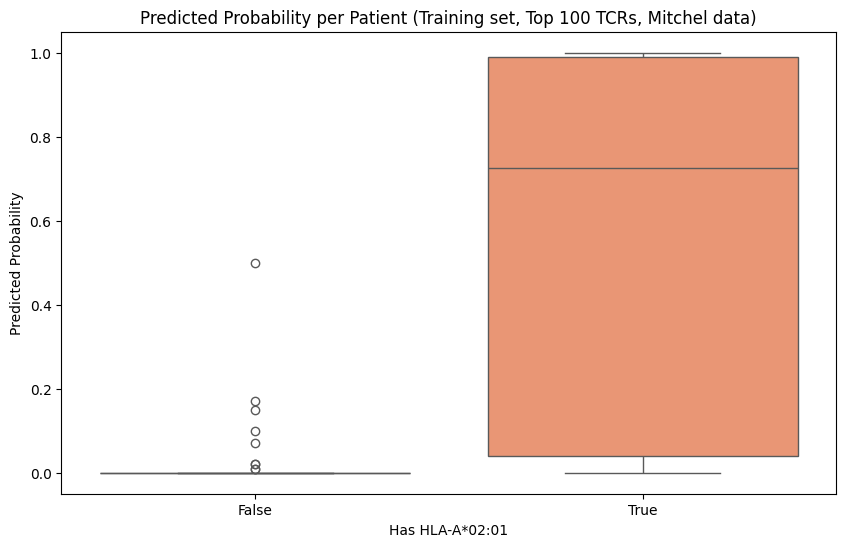

In [51]:
af.plot_box_plot(result_df_mitchel, 100)

In [34]:
result_df_mitchel['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True     108
False    108
Name: count, dtype: int64

In [28]:
result_df_mitchel['prediction'].value_counts()

prediction
0    279
1     80
Name: count, dtype: int64

In [119]:
#calculate average probability
average_probability = result_df_mitchel['probability'].mean()
average_probability

0.22986072423398332

In [120]:
#calculate median of probability of model
median_probability = result_df_mitchel['probability'].median()
median_probability

0.0

In [33]:
#calculate accuracy, sensitivity and specificity
# True labels are 'has_HLA_A02_01', predicted label is 'prediction'
result_df_mitchel['has_HLA_A02_01'] =result_df_mitchel['has_HLA_A02_01'].replace('None', np.nan)

#drop none values
result_df_mitchel = result_df_mitchel.dropna()
result_df_mitchel['has_HLA_A02_01_label'] = result_df_mitchel['has_HLA_A02_01'].astype('category').cat.codes

af.calculate_metrics(result_df_mitchel)



Sensitivity: 0.58
Specificity: 1.00
Accuracy: 0.79
              precision    recall  f1-score   support

     Class 0       0.71      1.00      0.83       108
     Class 1       1.00      0.58      0.74       108

    accuracy                           0.79       216
   macro avg       0.85      0.79      0.78       216
weighted avg       0.85      0.79      0.78       216



C:\Users\fried\AppData\Local\Temp\ipykernel_19580\3998114544.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_mitchel['has_HLA_A02_01_label'] = result_df_mitchel['has_HLA_A02_01'].astype('category').cat.codes


(0.5833333333333334, 1.0, 0.7916666666666666)

In [122]:
result_df_mitchel['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True     108
False    108
Name: count, dtype: int64

In [123]:
#count how many positive labels have a probability of 0.8 or higher
result_df_mitchel[result_df_mitchel['probability'] >= 0.8]['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True    50
Name: count, dtype: int64

In [124]:
#count how many negative labels have a probability of 0.2 or lower
result_df_mitchel[result_df_mitchel['probability'] <= 0.15]['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
False    106
True      34
Name: count, dtype: int64

In [125]:
# Select only rows where prediction of positive (True) label is 0.8 or higher 
result_df_mitchel_filtered = result_df_mitchel[(result_df_mitchel['probability'] >= 0.8)]

In [126]:
result_df_mitchel_filtered['prediction'].value_counts()

prediction
1    50
Name: count, dtype: int64

In [99]:
train_result_df = result_df_mitchel_filtered[['repertoire_id', 'total_tcrs', 'related_tcrs','prediction']]
train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


C:\Users\fried\AppData\Local\Temp\ipykernel_27560\532396224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


Related TCRs fisher exact:  21222
Selected related TCRs:  100
Training set:  376
has_HLA_A02_01_label
0    361
1     15
Name: count, dtype: int64
Training set:  426
has_HLA_A02_01_label
0    361
1     65
Name: count, dtype: int64
ROC Logistic Regression top 100 related tcrs (Training set), Threshold = 15, Selected TCRs Patients = 25000, Semi-supervised


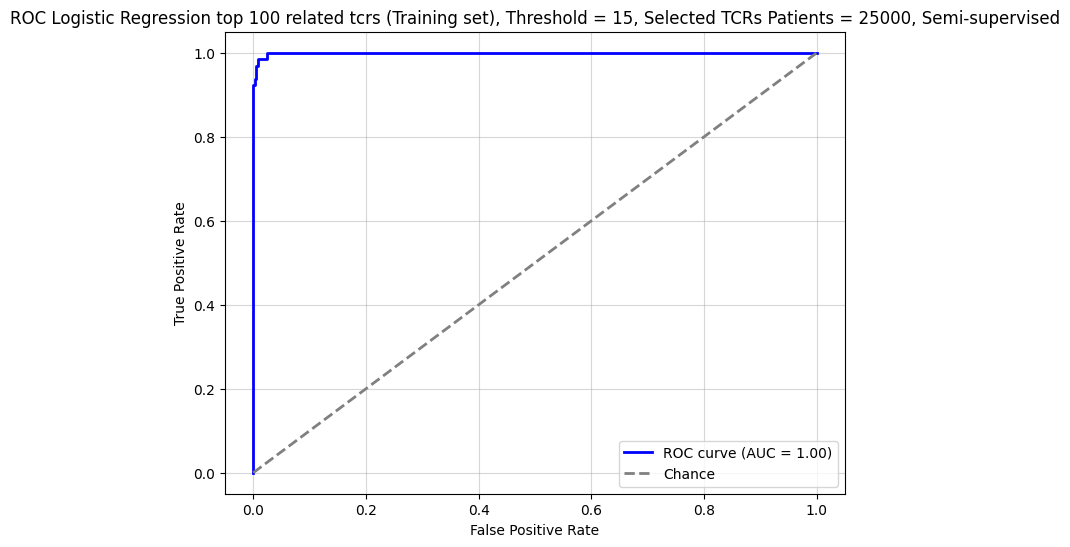

Sensitivity: 0.95
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       361
     Class 1       0.97      0.95      0.96        65

    accuracy                           0.99       426
   macro avg       0.98      0.97      0.98       426
weighted avg       0.99      0.99      0.99       426

Related TCRs fisher exact:  21222
Selected related TCRs:  100
Validation set:  257
ROC Logistic Regression top 100 related tcrs (Validation set), Threshold = 15, Selected TCRs Patients = 25000, Semi-supervised


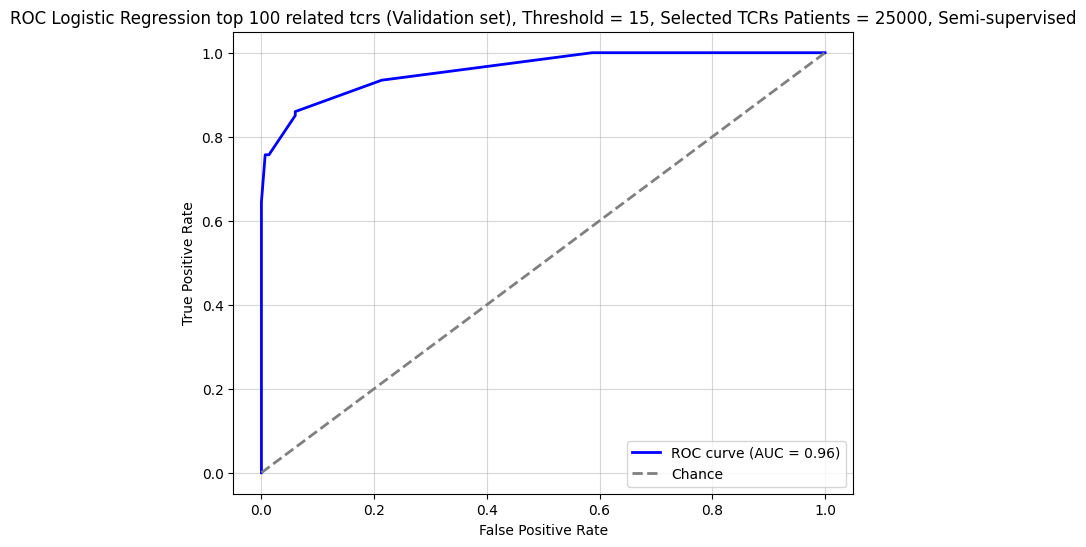

Sensitivity: 0.86
Specificity: 0.94
Accuracy: 0.91
              precision    recall  f1-score   support

     Class 0       0.90      0.94      0.92       150
     Class 1       0.91      0.86      0.88       107

    accuracy                           0.91       257
   macro avg       0.91      0.90      0.90       257
weighted avg       0.91      0.91      0.91       257



,top_n,threshold,selected_tcrs_per_patient,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,100,15,25000,False,0.959252,0.859813,0.94,0.906615


In [100]:
metrics_validation_data = []
metrics_training_data = []

bn = False
n = 100
threshold = 15
x = 25000

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_emerson = af.select_patients_hla_labelling(patient_df)
patient_df_emerson = af.select_positive_patients(patient_df_emerson, threshold)


fisher_exact_results_df_emerson = af.read_file('results\\7\\fisher_exact_results_threshold_' + str(threshold) + '.tsv')
fisher_exact_results_df_emerson['TCR'] = fisher_exact_results_df_emerson['TCR'].apply(ast.literal_eval)

result_df_emerson = af.preprocessing_dataset(fisher_exact_results_df_emerson, patient_df_emerson, '\\data\\HLA_emerson_2017', top_n=n, benjamini_hochberg=bn)

#training set
#select first 400 patients for training
result_df_training = result_df_emerson.iloc[:400]
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())
result_df_training = pd.concat([train_result_df, result_df_training], ignore_index=True)
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())

filename = 'results\\models\\logistic_regression_semi_supervised_training_selected_tcrs.joblib'
model, metrics_training = af.train_training_dataset(result_df_training, top_n=n, benjamini_hochberg=bn,threshold=threshold,selected_tcrs_patients=x,
                                                     filename_model=filename, semi_supervised=True)
metrics_training_data.append(metrics_training)

#validation set
patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)
result_df_validation = af.preprocessing_dataset(fisher_exact_results_df_emerson, patient_df_validation, '\\data\\HLA_emerson_2017', n, benjamini_hochberg=bn, selected_tcrs_patients=x)
metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn, model=model, threshold=threshold, selected_tcrs_patients=x, semi_supervised=True)
metrics_validation_data.append(metrics_validation)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_semi_supervised_selected_tcrs.tsv')
af.write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_semi_supervised.tsv_selected_tcrs')

metrics_training_df
metrics_validation_df

### 8. Select top x related TCR's using the convergence method

In [4]:
data = af.read_and_concatenate_files('\\data\\HLA_emerson_2017', number_of_patients=100)
af.write_to_file(data, 'results\\convergence_data_100.tsv')

In [4]:
data = af.read_file('results\\convergence_data.tsv')
data

,junction,v_call,junction_aa,j_call,duplicate_count,repertoire_id,chain
0,gtgccaccacgggtactagcgggggcccaagccagagtacgcagta...,TRBV10-3,CATTGTSGGPSQSTQYF,TRBJ2-3,44446,P00001_clonotypes,TRB
1,gtgccagcagcttacgagtcgggggctatggctacaccttc,TRBV7-9,CASSLRVGGYGYTF,TRBJ1-2,44049,P00001_clonotypes,TRB
2,gtgccagcagacgcctcggagggttgaacactgaagctttcttt,TRBV25-1,CASRRLGGLNTEAFF,TRBJ1-1,24891,P00001_clonotypes,TRB
3,gcgccagcagcttgagaggctctggaaacaccatatatttt,TRBV5-1,CASSLRGSGNTIYF,TRBJ1-3,14303,P00001_clonotypes,TRB
4,gtgccagcagacaggacgggagcactgaagctttcttt,TRBV6-1,CASRQDGSTEAFF,TRBJ1-1,12955,P00001_clonotypes,TRB
...,...,...,...,...,...,...,...
7725053,gcagcgttgaaggcgaggtagggactaggtcggccaaaaacattca...,TRBV29-1,CSVEGEVGTRSAKNIQYF,TRBJ2-4,2,P00050_clonotypes,TRB
7725054,gtgccggagacagggggcgaaagtcacccctccacttt,TRBV30,CAGDRGRKSPLHF,TRBJ1-6,2,P00050_clonotypes,TRB
7725055,gcgccagcagcttggaagggtggaacaatgagcagttcttc,TRBV5-1,CASSLEGWNNEQFF,TRBJ2-1,2,P00050_clonotypes,TRB
7725056,gtgccagcagccaagccgggacgaggggctacgagcagtacttc,TRBV4-2,CASSQAGTRGYEQYF,TRBJ2-5,2,P00050_clonotypes,TRB


In [5]:
patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = patient_df[patient_df['repertoire_id'].isin(data['repertoire_id'])]
#select only the patients that have label true in patient_df
positives = patient_df[patient_df['has_HLA_A02_01'] == True]
#make a list of the patients that are positives where the list containts the repertoire_id
positives = list(positives['repertoire_id'])
positives

['P00002_clonotypes',
 'P00003_clonotypes',
 'P00004_clonotypes',
 'P00006_clonotypes',
 'P00007_clonotypes',
 'P00008_clonotypes',
 'P00010_clonotypes',
 'P00011_clonotypes',
 'P00014_clonotypes',
 'P00017_clonotypes',
 'P00020_clonotypes',
 'P00021_clonotypes',
 'P00024_clonotypes',
 'P00030_clonotypes',
 'P00031_clonotypes',
 'P00032_clonotypes',
 'P00036_clonotypes',
 'P00037_clonotypes',
 'P00038_clonotypes',
 'P00042_clonotypes',
 'P00044_clonotypes',
 'P00045_clonotypes',
 'P00046_clonotypes',
 'P00048_clonotypes']

In [6]:
print(len(positives))

24


In [7]:
#print current time to see how long the function runs
import time
print("Start time: ", time.ctime())


Start time:  Fri Mar 14 18:03:04 2025


In [7]:
#convergence_results = af.convergence_method(data, positives)    

In [78]:
print("End time: ", time.ctime())

End time:  Wed Mar 12 18:40:28 2025


In [79]:
#af.write_to_file(convergence_results, 'results\\convergence_results_100.tsv')

In [20]:
convergence_results = af.read_file('results\\convergence_results.tsv')

In [21]:
convergence_results

,junction,v_call,junction_aa,j_call,duplicate_count,repertoire_id,chain,match_true,match_false,background_true,background_false,statistic,pvalue,convergence
0,gcgccagcagtgacagggacaccggggagctgtttttt,TRBV10-1*01,CASSDRDTGELFF,TRBJ2-2,2016,P00001_clonotypes,TRB,11,16,954,1071,0.748513,0.548560,-0.373671
1,gcgccagcagtacatcccacgagcagtacttc,TRBV10-1*01,CASSTSHEQYF,TRBJ2-7,1686,P00001_clonotypes,TRB,4,4,926,1118,1.207568,1.000000,0.271836
2,gcgccagcagtgagtcgtacggcagggggtcgtcggacactgaagc...,TRBV10-1*01,CASSESYGRGSSDTEAFF,TRBJ1-1,555,P00001_clonotypes,TRB,1,2,912,1137,0.000000,1.000000,-0.681873
3,gcgccagcagctacaggggtgaagctttcttt,TRBV10-1*01,CASSYRGEAFF,TRBJ1-1,473,P00001_clonotypes,TRB,1,4,904,1143,0.000000,0.260111,-1.661569
4,gcgccagcagtgcgcccaactatggctacaccttc,TRBV10-1*01,CASSAPNYGYTF,TRBJ1-2,378,P00001_clonotypes,TRB,1,4,898,1149,0.000000,0.261176,-1.644409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7725053,gtgccagcagcgtctcggacagagaacaccgggaccccaacaccgg...,TRBV9*01,CASSVSDREHRDPNTGELFF,TRBJ2-2,2,P00050_clonotypes,TRB,1,2,897,1152,0.000000,1.000000,-0.639039
7725054,gtgccagcagcgtctggacagggttcccagatacgcggtatttt,TRBV9*01,CASSVWTGFPDTRYF,TRBJ2-3,2,P00050_clonotypes,TRB,1,3,904,1144,0.000000,0.506741,-1.245270
7725055,gtgccagcagcgtcttcggtcggggggggaataaaaacattcagta...,TRBV9*01,CASSVFGRGGNKNIQYF,TRBJ2-4,2,P00050_clonotypes,TRB,1,2,910,1139,0.000000,1.000000,-0.676171
7725056,gtgccagcagcgtctcgcaccaggggaacactgaagccttcttt,TRBV9*01,CASSVSHQGNTEAFF,TRBJ1-1,2,P00050_clonotypes,TRB,7,5,872,1168,2.009759,0.342077,0.907067


In [22]:
convergence_results.sort_values(by=['pvalue'], inplace=True, ignore_index=True)

In [23]:
convergence_results.head(10)

,junction,v_call,junction_aa,j_call,duplicate_count,repertoire_id,chain,match_true,match_false,background_true,background_false,statistic,pvalue,convergence
0,gtgccagtagtcttaggtcctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,12,P00038_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
1,gtgccagtagtttacggagctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,27,P00017_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
2,gtgccagtagtcttaggtcctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,17,P00001_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
3,gtgccagttccctacggagctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,10,P00014_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
4,gtgccagtagcttacggagctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,11,P00048_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
5,gtgccagtagtctcagaagttcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,14,P00007_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
6,gtgccagtagtctccggagctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,117,P00038_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
7,gtgccagtaatataaggtcctcctacgagcagtacttc,TRBV19*01,CASNIRSSYEQYF,TRBJ2-7,47,P00031_clonotypes,TRB,262,19,809,962,17.245668,1.157875e-58,4.035393
8,gtgccagtagtattcggagtcagtacgagcagtacttc,TRBV19*01,CASSIRSQYEQYF,TRBJ2-7,60,P00004_clonotypes,TRB,250,19,815,968,16.433456,1.668417e-55,3.966064
9,gtgccagtagtattcggagtcagtacgagcagtacttc,TRBV19*01,CASSIRSQYEQYF,TRBJ2-5,4,P00004_clonotypes,TRB,250,19,816,967,16.396319,1.911937e-55,3.962804


In [24]:
#remomve duplicate rows: where v_call, j_call, junction_aa and convergence are the same
print("Number of rows before removing duplicates: ", len(convergence_results))
convergence_results = convergence_results.drop_duplicates(subset=['v_call', 'j_call', 'junction_aa', 'convergence'], keep='first', ignore_index=True)
print("Number of rows after removing duplicates: ", len(convergence_results))

Number of rows before removing duplicates:  7725058
Number of rows after removing duplicates:  6792082


In [14]:
convergence_results.head(10)

,junction,v_call,junction_aa,j_call,duplicate_count,repertoire_id,chain,match_true,match_false,background_true,background_false,statistic,pvalue,convergence
0,gtgccagtagtcttaggtcctcctacgagcagtacttc,TRBV19*01,CASSLRSSYEQYF,TRBJ2-7,12,P00038_clonotypes,TRB,303,34,765,950,11.367523,2.338180e-59,3.468179
7,gtgccagtaatataaggtcctcctacgagcagtacttc,TRBV19*01,CASNIRSSYEQYF,TRBJ2-7,47,P00031_clonotypes,TRB,262,19,809,962,17.245668,1.157875e-58,4.035393
8,gtgccagtagtattcggagtcagtacgagcagtacttc,TRBV19*01,CASSIRSQYEQYF,TRBJ2-7,60,P00004_clonotypes,TRB,250,19,815,968,16.433456,1.668417e-55,3.966064
9,gtgccagtagtattcggagtcagtacgagcagtacttc,TRBV19*01,CASSIRSQYEQYF,TRBJ2-5,4,P00004_clonotypes,TRB,250,19,816,967,16.396319,1.911937e-55,3.962804
10,gtgccagtagtatccgttcgaactacgagcagtacttc,TRBV19*01,CASSIRSNYEQYF,TRBJ2-7,7,P00040_clonotypes,TRB,275,31,789,957,11.080541,1.353725e-53,3.427585
11,gtgccagtagtattcggtctgcgtacgagcagtacttc,TRBV19*01,CASSIRSAYEQYF,TRBJ2-7,15,P00014_clonotypes,TRB,302,42,780,928,8.736247,1.225744e-51,3.096738
14,gtgccagtagtataaggtcagcgtatgagcagttcttc,TRBV19*01,CASSIRSAYEQFF,TRBJ2-1,10,P00014_clonotypes,TRB,302,42,780,928,8.736247,1.225744e-51,3.096738
49,gtgccagtagtattaagagctcctacgagcagtacttc,TRBV19*01,CASSIKSSYEQYF,TRBJ2-7,3,P00046_clonotypes,TRB,292,47,748,965,8.163786,8.837504e-51,3.002726
51,gtgccagtagtgtccgtagctcctacgagcagtacttc,TRBV19*01,CASSVRSSYEQYF,TRBJ2-7,359,P00014_clonotypes,TRB,342,65,735,910,6.598455,7.025667e-50,2.703607
55,gtgccacctcggtcaggagctcctacgagcagtacttc,TRBV19*01,CATSVRSSYEQYF,TRBJ2-7,194,P00032_clonotypes,TRB,342,65,735,910,6.598455,7.025667e-50,2.703607


In [12]:
#read fisher-exact results from file
#df = af.read_file('results\\fisher_exact_results.tsv')
#df

In [32]:
importlib.reload(af)

<module 'analysis_functions' from 'c:\\Users\\fried\\Desktop\\Project_emerson\\analysis_functions.py'>

In [4]:
top_n = [5, 10, 20, 30, 50, 90, 100, 500, 1000, 5000, 10000, 20000]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_training = af.select_patients_hla_labelling(patient_df, number_of_patients=50)
patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)


convergence_results_df = af.read_file('results\\8\\convergence_results.tsv')
#remomve duplicate rows: where v_call, j_call, junction_aa and convergence are the same
print("Before removing duplicates: ", len(convergence_results_df))
convergence_results_df = convergence_results_df.drop_duplicates(subset=['v_call', 'j_call', 'junction_aa', 'convergence'], keep='first', ignore_index=True)
print("After removing duplicates: ", len(convergence_results_df))
convergence_results_df.rename(columns={'pvalue': 'p_value', 'convergence': 'odds_ratio'}, inplace=True)
#v_call currently is in the format TRBV7-2*01, we want to split this into, TRBV7-2 and 01 and olny keep the first part
convergence_results_df['v_call'] = convergence_results_df['v_call'].apply(lambda x: x.split('*')[0])
patients_path = '\\data\\HLA_emerson_2017'

bn = False


for n in top_n:
    #result_df_training_plot = result_df_copy.iloc[:400]
    #af.plot_total_vs_significant_tcrs(result_df_training_plot, n)
    result_df = af.preprocessing_dataset(convergence_results_df, patient_df_training, patients_path, top_n=n, benjamini_hochberg=bn)
    filename = 'results\\8\\logistic_regression_top' + str(n) + '_convergence_method.joblib'
    model, metrics_training = af.train_training_dataset(result_df, top_n=n, benjamini_hochberg=bn, filename_model=filename, 
                                                        convergence_method=True, folder='results\\8')
    metrics_training_data.append(metrics_training)

    #validation set
    result_df_validation = af.preprocessing_dataset(convergence_results_df, patient_df_validation, patients_path, top_n=n, benjamini_hochberg=bn)
    metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn, 
                                                        model=model, convergence_method=True, folder='results\\8')
    metrics_validation_data.append(metrics_validation)

    
metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\8\\metrics_classifiers_training_convergence_method.tsv')
af.write_to_file(metrics_validation_df, 'results\\8\\metrics_classifiers_validation_convergence_method.tsv')

metrics_training_df
metrics_validation_df

Before removing duplicates:  7725058
After removing duplicates:  6792082
Related TCRs fisher exact:  64976
Selected related TCRs:  5
Selected related TCRs:                                       junction  v_call    junction_aa   j_call  \
8295   gtgccagtagtcttaggtcctcctacgagcagtacttc  TRBV19  CASSLRSSYEQYF  TRBJ2-7   
10803  gtgccagtaatataaggtcctcctacgagcagtacttc  TRBV19  CASNIRSSYEQYF  TRBJ2-7   
8542   gtgccagtagtattcggagtcagtacgagcagtacttc  TRBV19  CASSIRSQYEQYF  TRBJ2-7   
8688   gtgccagtagtattcggagtcagtacgagcagtacttc  TRBV19  CASSIRSQYEQYF  TRBJ2-5   
11693  gtgccagtagtatccgttcgaactacgagcagtacttc  TRBV19  CASSIRSNYEQYF  TRBJ2-7   

       duplicate_count      repertoire_id chain  match_true  match_false  \
8295                17  P00001_clonotypes   TRB         303           34   
10803               47  P00031_clonotypes   TRB         262           19   
8542                60  P00004_clonotypes   TRB         250           19   
8688                 4  P00004_clonotypes   TRB     

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [59]:
#convert metrics_validation_df to a dataframe, each column is currently representes as a dictionary
#each key should represent the column name
#convert the dictionary to a dataframe
metrics_validation_df = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_validation_convergence_method.tsv'))
metrics_validation_df.iloc[:, 0] = metrics_validation_df.iloc[:, 0].apply(ast.literal_eval)

# Now expand the dictionary
metrics_validation_df = metrics_validation_df.iloc[:, 0].apply(pd.Series)
#metrics_validation_df_expanded = metrics_validation_df.iloc[:, 0].apply(pd.Series)
metrics_validation_df



,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,None,None,False,0.491713,0.000000,1.000000,0.583658
1,10,None,None,False,0.491713,0.000000,1.000000,0.583658
2,20,None,None,False,0.491713,0.000000,1.000000,0.583658
3,30,None,None,False,0.923863,0.700935,0.986667,0.867704
4,50,None,None,False,0.906231,0.691589,0.986667,0.863813
5,90,None,None,False,0.895701,0.672897,0.966667,0.844358
6,100,None,None,False,0.893769,0.682243,0.953333,0.840467
7,500,None,None,False,0.953209,0.869159,0.926667,0.902724
8,1000,None,None,False,0.879003,0.570093,0.973333,0.805447


In [60]:
metrics_training_df_expanded = metrics_training_df.iloc[:, 0].apply(pd.Series)
metrics_training_df_expanded

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,None,None,False,0.603333,0.000000,1.00,0.510204
1,10,None,None,False,0.603333,0.000000,1.00,0.510204
2,20,None,None,False,0.603333,0.000000,1.00,0.510204
3,30,None,None,False,0.930000,0.875000,1.00,0.938776
4,50,None,None,False,0.916667,0.875000,0.96,0.918367
5,90,None,None,False,0.921667,0.875000,0.96,0.918367
6,100,None,None,False,0.925000,0.875000,0.96,0.918367
7,500,None,None,False,1.000000,0.958333,1.00,0.979592
8,1000,None,None,False,1.000000,1.000000,1.00,1.000000


### 8.2 Execute Fisher exact method for 50 patients (to compare with convergence method)
##### In function matching_patients_tcrs there is now no limit of number of occurences (default is minimum 5 occurences)

In [6]:
tcr_df = af.matching_patients_tcrs('\\data\\HLA_emerson_2017', number_of_patients=50, min_occurences=0)
af.write_to_file(tcr_df, 'results\\8\\tcr_df_output_50_no_min_occurences.tsv')

In [7]:
len(tcr_df)

6772728

In [8]:
patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df = af.select_patients_hla_labelling(patient_df, number_of_patients=50)

len(patient_df)

49

In [9]:
fisher_exact_results_df = af.execute_fisher_exact(tcr_df, patient_df)
af.write_to_file(fisher_exact_results_df, 'results\\8\\fisher_exact_results_50_no_limit_occurences.tsv')

c:\Users\fried\miniconda3\envs\env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
related_tcrs = fisher_exact_results_df[(fisher_exact_results_df['p_value'] < 0.05) & (fisher_exact_results_df['odds_ratio'] > 1)].reset_index(drop=True)
print("Related TCRs fisher exact: ",len(related_tcrs)) 

Related TCRs fisher exact:  687


In [ ]:
top_n = [5, 10, 20, 30, 50, 90, 100, 500]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_training = af.select_patients_hla_labelling(patient_df, number_of_patients=50)
patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)


fisher_exact_results_df = af.read_file('results\\8\\fisher_exact_results_50.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
patients_path = '\\data\\HLA_emerson_2017'

bn = False


for n in top_n:
    #result_df_training_plot = result_df_copy.iloc[:400]
    #af.plot_total_vs_significant_tcrs(result_df_training_plot, n)
    result_df = af.preprocessing_dataset(fisher_exact_results_df, patient_df_training, patients_path, top_n=n, benjamini_hochberg=bn)
    filename = 'results\\models\\logistic_regression_top' + str(n) + '_fisher_exact_50.joblib'
    model, metrics_training = af.train_training_dataset(result_df, top_n=n, benjamini_hochberg=bn, threshold=50,
                                                         filename_model=filename, folder='results\\8')
    metrics_training_data.append(metrics_training)

    #validation set
    result_df_validation = af.preprocessing_dataset(fisher_exact_results_df, patient_df_validation, patients_path, top_n=n, benjamini_hochberg=bn)
    metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn,
                                                        threshold=50, model=model, folder='results\\8')
    metrics_validation_data.append(metrics_validation)

    
metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\8\\metrics_classifiers_training_50_patients.tsv')
af.write_to_file(metrics_validation_df, 'results\\8\\metrics_classifiers_validation_50_patients.tsv')

metrics_training_df


In [22]:
metrics_training_df = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_training_50_patients.tsv'))
metrics_training_df.iloc[:, 0] = metrics_training_df.iloc[:, 0].apply(ast.literal_eval)

# Now expand the dictionary
metrics_training_df = metrics_training_df.iloc[:, 0].apply(pd.Series)

metrics_training_df

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,50,None,False,0.603333,0.000000,1.0,0.510204
1,10,50,None,False,0.993333,0.958333,1.0,0.979592
2,20,50,None,False,0.995000,0.958333,1.0,0.979592
3,30,50,None,False,1.000000,1.000000,1.0,1.000000
4,50,50,None,False,1.000000,1.000000,1.0,1.000000
5,90,50,None,False,1.000000,1.000000,1.0,1.000000
6,100,50,None,False,1.000000,1.000000,1.0,1.000000
7,500,50,None,False,1.000000,1.000000,1.0,1.000000


In [28]:
metrics_training_convergence = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_training_convergence_method.tsv'))
metrics_training_convergence.iloc[:, 0] = metrics_training_convergence.iloc[:, 0].apply(ast.literal_eval)
metrics_training_convergence = metrics_training_convergence.iloc[:, 0].apply(pd.Series)
metrics_training_convergence

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,None,None,False,0.603333,0.000000,1.00,0.510204
1,10,None,None,False,0.603333,0.000000,1.00,0.510204
2,20,None,None,False,0.603333,0.000000,1.00,0.510204
3,30,None,None,False,0.930000,0.875000,1.00,0.938776
4,50,None,None,False,0.916667,0.875000,0.96,0.918367
5,90,None,None,False,0.921667,0.875000,0.96,0.918367
6,100,None,None,False,0.925000,0.875000,0.96,0.918367
7,500,None,None,False,1.000000,0.958333,1.00,0.979592
8,1000,None,None,False,1.000000,1.000000,1.00,1.000000


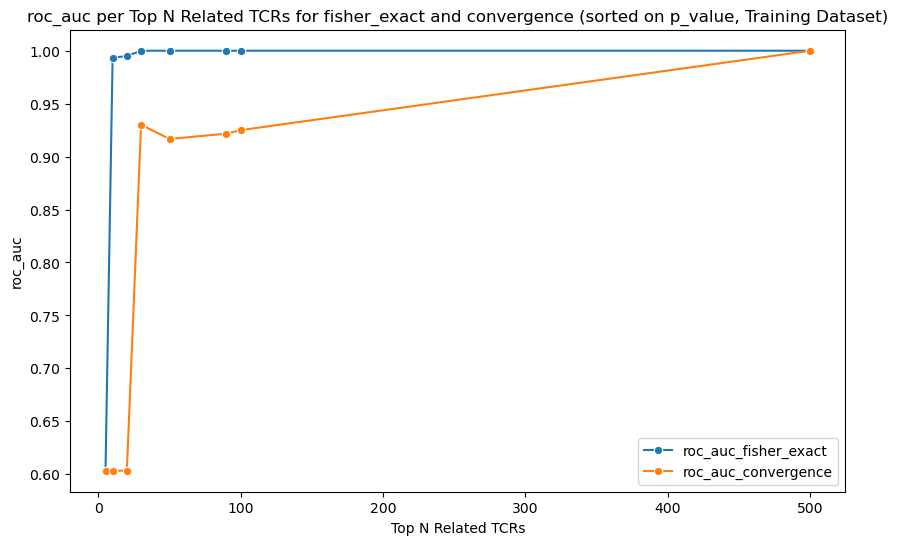

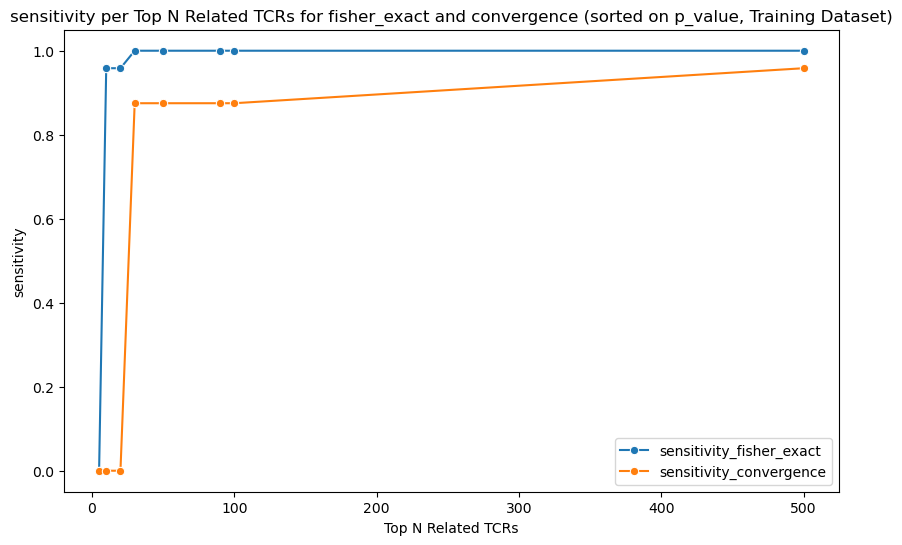

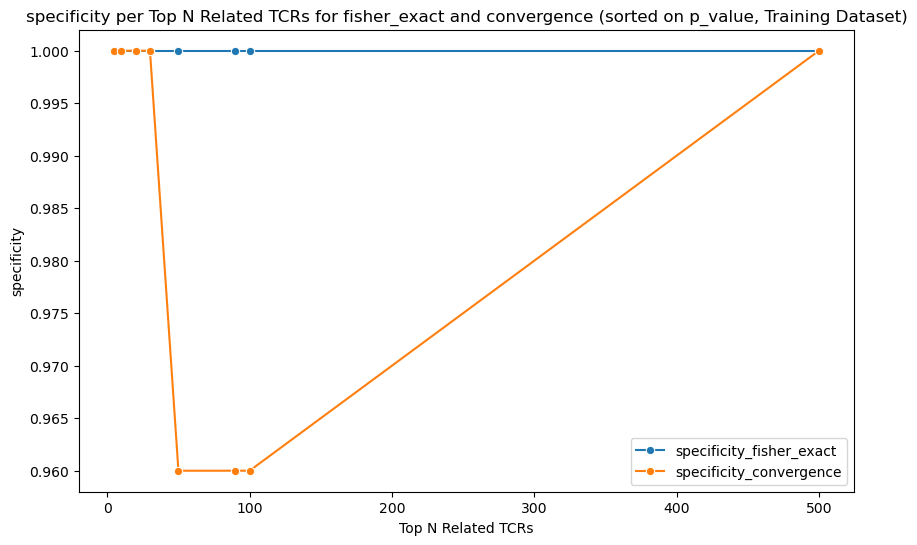

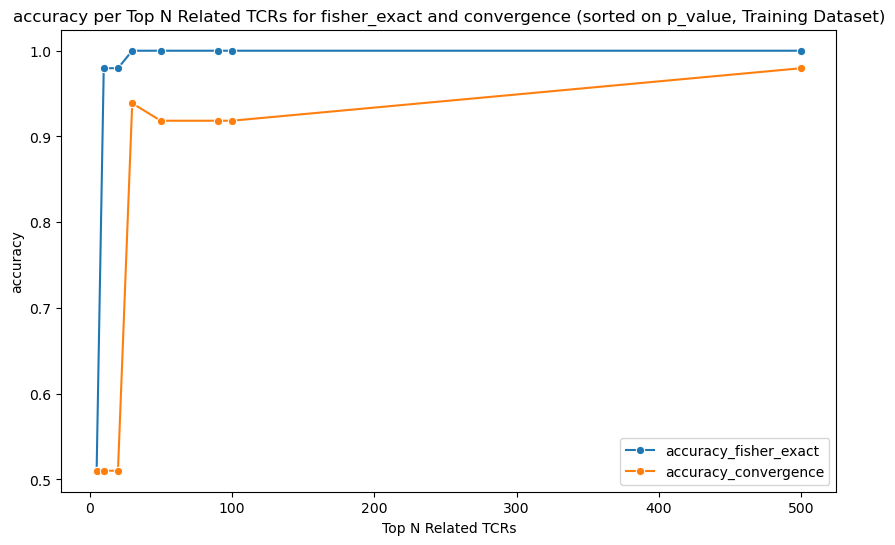

In [48]:
# All metrics to compare for training 
for col in ['roc_auc', 'sensitivity', 'specificity', 'accuracy']:
    af.plot_line_plot(metrics_training_df,metrics_training_convergence, 
                      compare_metric=col, folder='results\\8')




In [49]:
metrics_validation_df = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_validation_50_patients.tsv'))
metrics_validation_df.iloc[:, 0] = metrics_validation_df.iloc[:, 0].apply(ast.literal_eval)

# Now expand the dictionary
metrics_validation_df = metrics_validation_df.iloc[:, 0].apply(pd.Series)
#metrics_validation_df_expanded = metrics_validation_df.iloc[:, 0].apply(pd.Series)
metrics_validation_df

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,50,None,False,0.491713,0.000000,1.000000,0.583658
1,10,50,None,False,0.933022,0.859813,0.886667,0.875486
2,20,50,None,False,0.945483,0.934579,0.773333,0.840467
3,30,50,None,False,0.935576,0.887850,0.886667,0.887160
4,50,50,None,False,0.928224,0.850467,0.893333,0.875486
5,90,50,None,False,0.947975,0.822430,0.973333,0.910506
6,100,50,None,False,0.923178,0.747664,0.946667,0.863813
7,500,50,None,False,0.790280,0.196262,0.980000,0.653696


In [50]:
metrics_validation_convergence = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_validation_convergence_method.tsv'))
metrics_validation_convergence.iloc[:, 0] = metrics_validation_convergence.iloc[:, 0].apply(ast.literal_eval)
metrics_validation_convergence = metrics_validation_convergence.iloc[:, 0].apply(pd.Series)
metrics_validation_convergence

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,None,None,False,0.491713,0.000000,1.000000,0.583658
1,10,None,None,False,0.491713,0.000000,1.000000,0.583658
2,20,None,None,False,0.491713,0.000000,1.000000,0.583658
3,30,None,None,False,0.923863,0.700935,0.986667,0.867704
4,50,None,None,False,0.906231,0.691589,0.986667,0.863813
5,90,None,None,False,0.895701,0.672897,0.966667,0.844358
6,100,None,None,False,0.893769,0.682243,0.953333,0.840467
7,500,None,None,False,0.953209,0.869159,0.926667,0.902724
8,1000,None,None,False,0.879003,0.570093,0.973333,0.805447


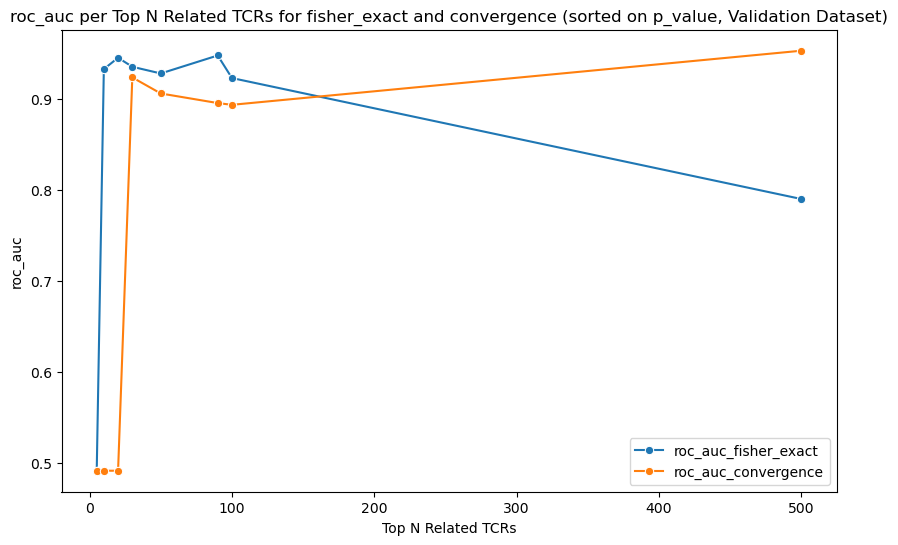

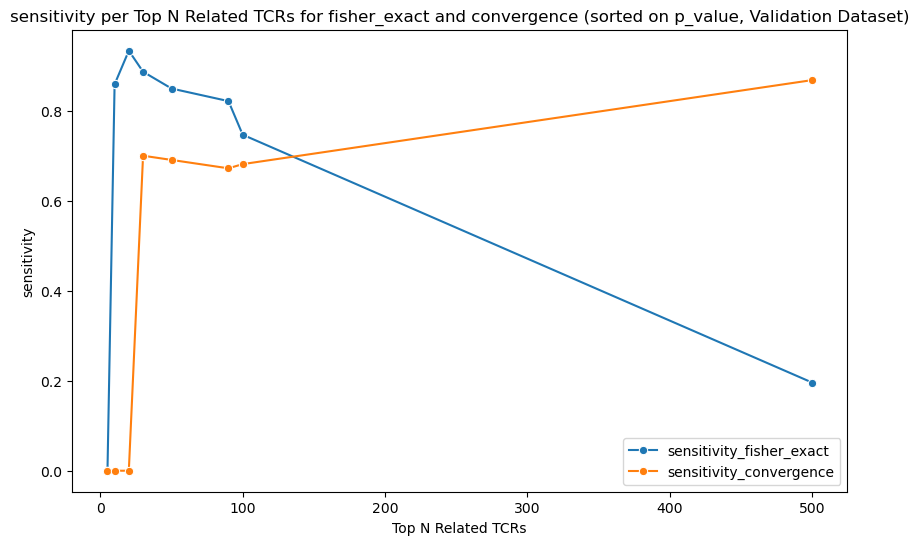

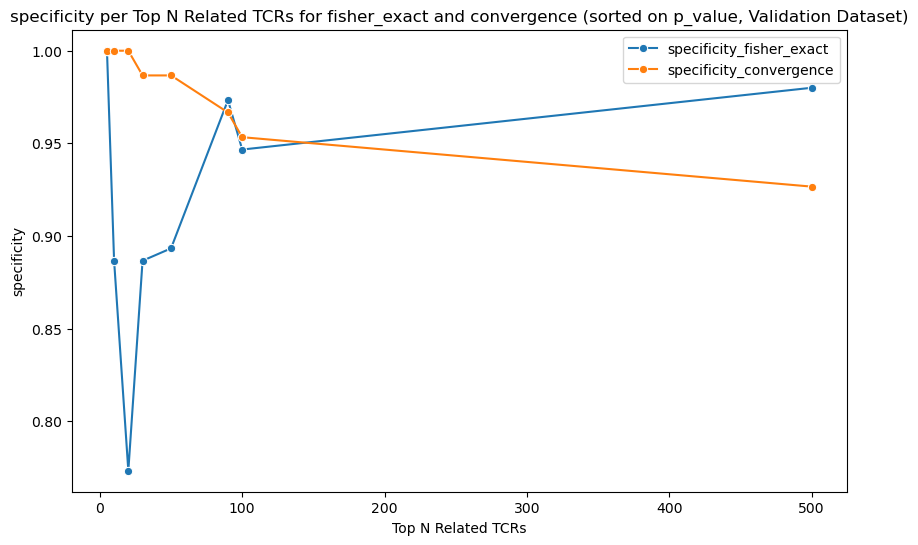

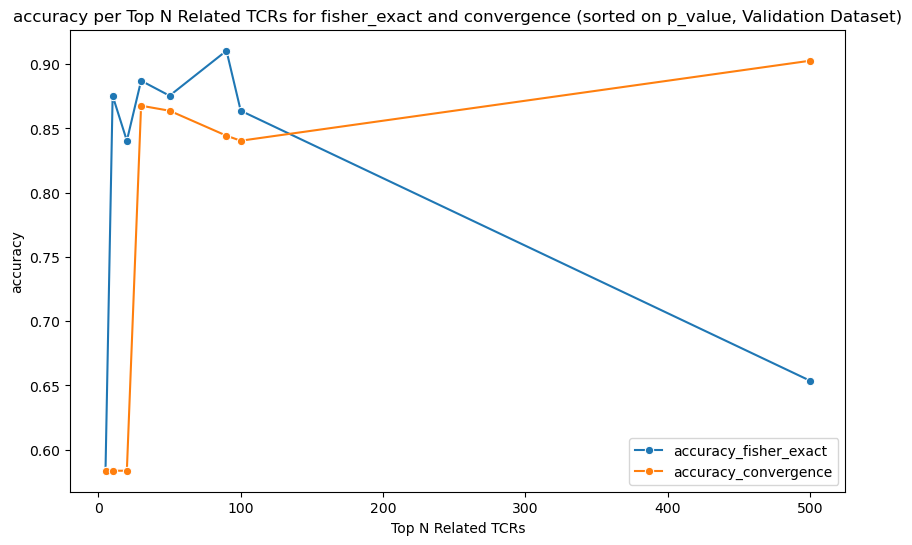

In [51]:
# All metrics to compare for validation
for col in ['roc_auc', 'sensitivity', 'specificity', 'accuracy']:
    af.plot_line_plot(metrics_validation_df,metrics_validation_convergence, 
                      compare_metric=col, folder='results\\8', training=False)

#### 8.3 Sort values for top related TCR's on column 'odd_ratio' instead of 'p_value'

In [ ]:
top_n =  [5, 10, 20, 30, 50, 90, 100, 500]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_training = af.select_patients_hla_labelling(patient_df, number_of_patients=50)
patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)


fisher_exact_results_df = af.read_file('results\\8\\fisher_exact_results_50.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
patients_path = '\\data\\HLA_emerson_2017'

bn = False


for n in top_n:
    #result_df_training_plot = result_df_copy.iloc[:400]
    #af.plot_total_vs_significant_tcrs(result_df_training_plot, n)
    result_df = af.preprocessing_dataset(fisher_exact_results_df, patient_df_training, patients_path, 
                                         top_n=n, benjamini_hochberg=bn, sort_column='odds_ratio')
    filename = 'results\\models\\logistic_regression_top' + str(n) + '_fisher_exact_50_odds_ratio.joblib'
    model, metrics_training = af.train_training_dataset(result_df, top_n=n, benjamini_hochberg=bn, threshold=50,
                                                         filename_model=filename, folder='results\\8', sort_column='odds_ratio')
    metrics_training_data.append(metrics_training)

    #validation set
    result_df_validation = af.preprocessing_dataset(fisher_exact_results_df, patient_df_validation, patients_path, 
                                                    top_n=n, benjamini_hochberg=bn, sort_column='odds_ratio')
    metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn,
                                                        threshold=50, model=model, folder='results\\8', sort_column='odds_ratio')
    metrics_validation_data.append(metrics_validation)

    
metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\8\\metrics_classifiers_training_50_patients_odds_ratio.tsv')
af.write_to_file(metrics_validation_df, 'results\\8\\metrics_classifiers_validation_50_patients_odds_ratio.tsv')

metrics_training_df


In [86]:
metrics_validation_df

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,sort_column,roc_auc,sensitivity,specificity,accuracy
0,5,50,None,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
1,10,50,None,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
2,20,50,None,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
3,30,50,None,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
4,50,50,None,False,odds_ratio,0.672212,0.850467,0.400000,0.587549
5,90,50,None,False,odds_ratio,0.689533,0.934579,0.146667,0.474708
6,100,50,None,False,odds_ratio,0.691776,0.943925,0.146667,0.478599
7,500,50,None,False,odds_ratio,0.801059,0.224299,0.986667,0.669261


In [ ]:
top_n =  [5, 10, 20, 30, 50, 90, 100, 500]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_training = af.select_patients_hla_labelling(patient_df, number_of_patients=50)
patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)


convergence_results_df = af.read_file('results\\8\\convergence_results.tsv')
#remomve duplicate rows: where v_call, j_call, junction_aa and convergence are the same
print("Before removing duplicates: ", len(convergence_results_df))
convergence_results_df = convergence_results_df.drop_duplicates(subset=['v_call', 'j_call', 'junction_aa', 'convergence'], keep='first', ignore_index=True)
print("After removing duplicates: ", len(convergence_results_df))
convergence_results_df.rename(columns={'pvalue': 'p_value', 'convergence': 'odds_ratio'}, inplace=True)
#v_call currently is in the format TRBV7-2*01, we want to split this into, TRBV7-2 and 01 and olny keep the first part
convergence_results_df['v_call'] = convergence_results_df['v_call'].apply(lambda x: x.split('*')[0])
patients_path = '\\data\\HLA_emerson_2017'

bn = False


for n in top_n:
    #result_df_training_plot = result_df_copy.iloc[:400]
    #af.plot_total_vs_significant_tcrs(result_df_training_plot, n)
    result_df = af.preprocessing_dataset(convergence_results_df, patient_df_training, patients_path, 
                                         top_n=n, benjamini_hochberg=bn, sort_column='odds_ratio')
    filename = 'results\\models\\logistic_regression_top' + str(n) + '_convergence_odds_ratio.joblib'
    model, metrics_training = af.train_training_dataset(result_df, top_n=n, benjamini_hochberg=bn, threshold=50,
                                                         filename_model=filename, convergence_method=True ,folder='results\\8', sort_column='odds_ratio')
    metrics_training_data.append(metrics_training)

    #validation set
    result_df_validation = af.preprocessing_dataset(convergence_results_df, patient_df_validation, patients_path, 
                                                    top_n=n, benjamini_hochberg=bn, sort_column='odds_ratio')
    metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn,
                                                        threshold=50, model=model, convergence_method=True,
                                                          folder='results\\8', sort_column='odds_ratio')
    metrics_validation_data.append(metrics_validation)

    
metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\8\\metrics_classifiers_training_convergence_method_odds_ratio.tsv')
af.write_to_file(metrics_validation_df, 'results\\8\\metrics_classifiers_validation_convergence_method_odds_ratio.tsv')

metrics_training_df


In [96]:
metrics_training_df_fisher = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_training_50_patients_odds_ratio.tsv'))
metrics_training_df_convergence = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_training_convergence_method_odds_ratio.tsv'))
metrics_training_df_fisher

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,sort_column,roc_auc,sensitivity,specificity,accuracy
0,5,50,NaN,False,odds_ratio,0.603333,0.000000,1.0,0.510204
1,10,50,NaN,False,odds_ratio,0.603333,0.000000,1.0,0.510204
2,20,50,NaN,False,odds_ratio,0.603333,0.000000,1.0,0.510204
3,30,50,NaN,False,odds_ratio,0.603333,0.000000,1.0,0.510204
4,50,50,NaN,False,odds_ratio,0.983333,0.916667,1.0,0.959184
5,90,50,NaN,False,odds_ratio,0.996667,0.958333,1.0,0.979592
6,100,50,NaN,False,odds_ratio,0.996667,0.958333,1.0,0.979592
7,500,50,NaN,False,odds_ratio,1.000000,1.000000,1.0,1.000000


In [101]:
# All metrics to compare for training
#for col in ['roc_auc', 'sensitivity', 'specificity', 'accuracy']:
#    af.plot_line_plot(metrics_training_df_fisher,metrics_training_df_convergence, 
#                      compare_metric=col, folder='results\\8', sort_column='odds_ratio')

In [97]:
metrics_validation_df_fisher = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_validation_50_patients_odds_ratio.tsv'))
metrics_validation_df_convergence = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_validation_convergence_method_odds_ratio.tsv'))


In [104]:
metrics_validation_df_fisher

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,sort_column,roc_auc,sensitivity,specificity,accuracy
0,5,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
1,10,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
2,20,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
3,30,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
4,50,50,NaN,False,odds_ratio,0.672212,0.850467,0.400000,0.587549
5,90,50,NaN,False,odds_ratio,0.689533,0.934579,0.146667,0.474708
6,100,50,NaN,False,odds_ratio,0.691776,0.943925,0.146667,0.478599
7,500,50,NaN,False,odds_ratio,0.801059,0.224299,0.986667,0.669261


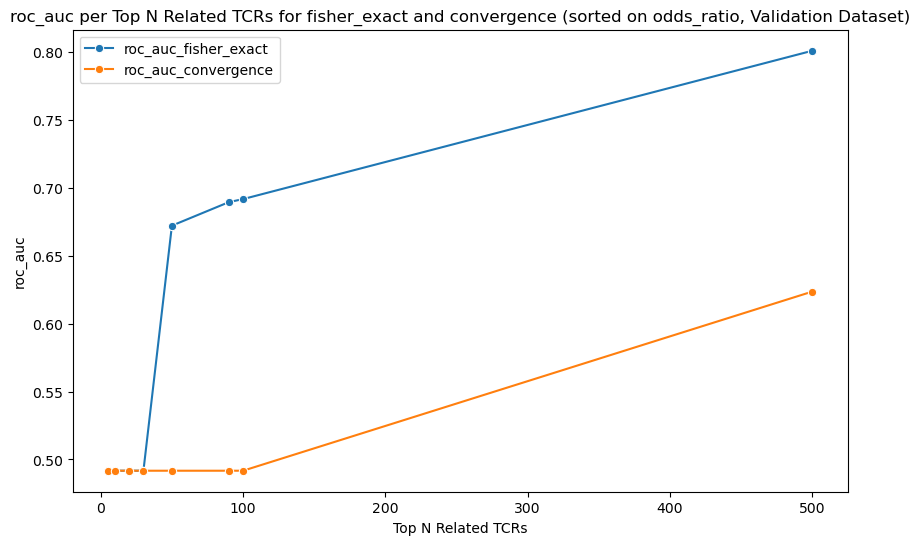

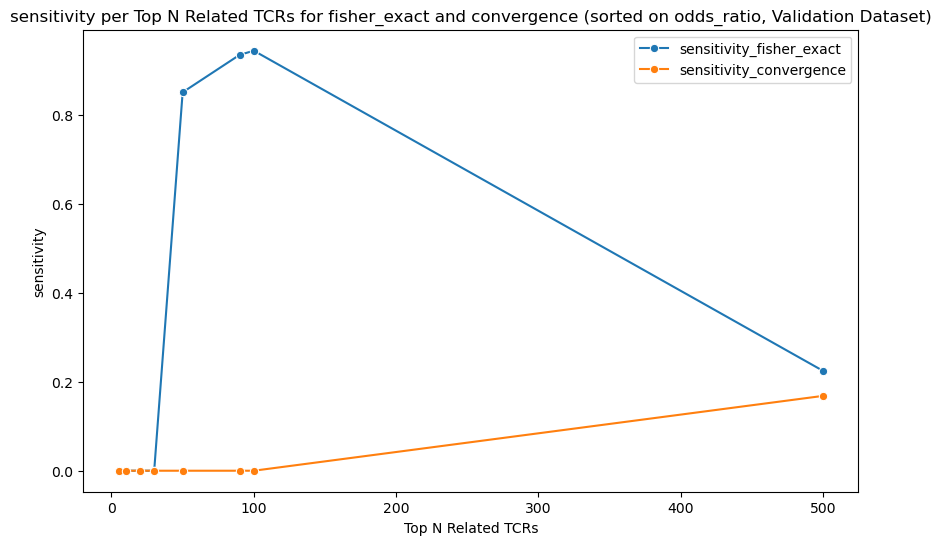

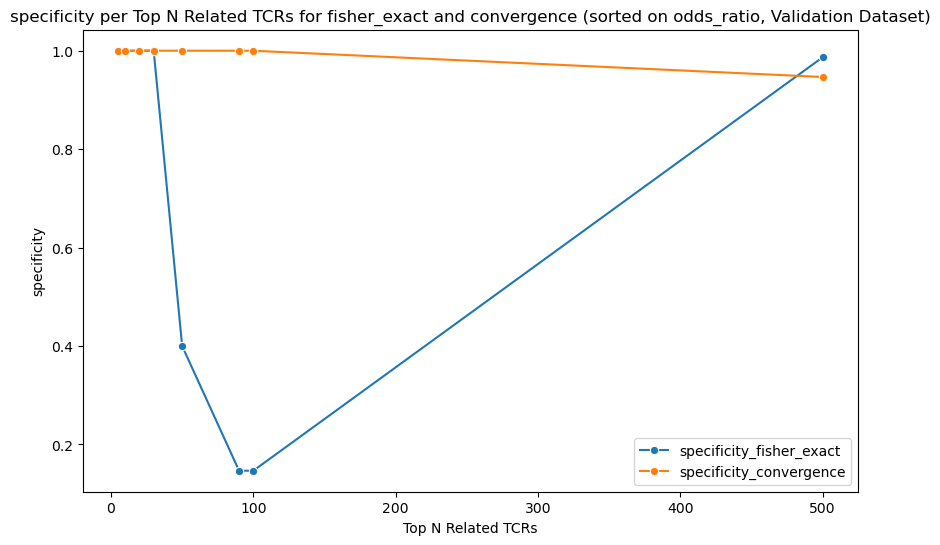

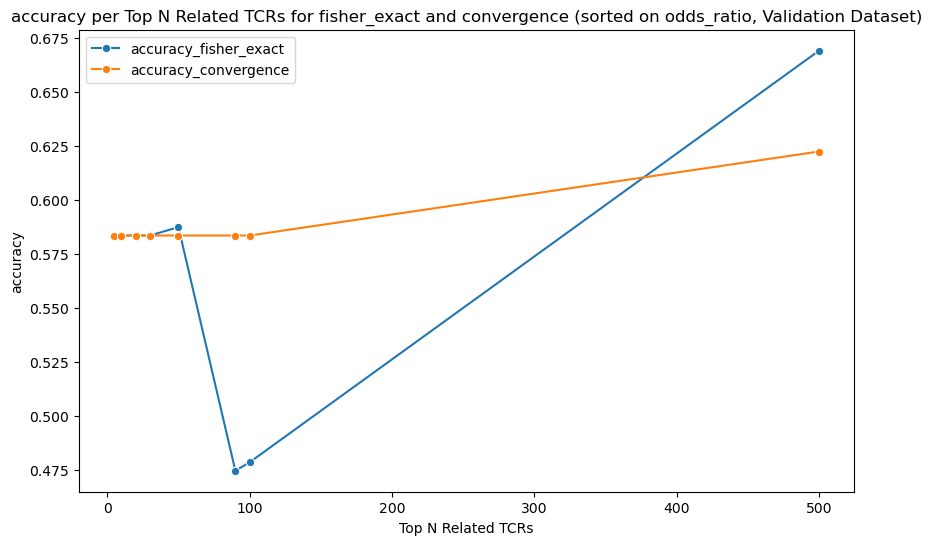

In [105]:
# All metrics to compare for validation
for col in ['roc_auc', 'sensitivity', 'specificity', 'accuracy']:
    af.plot_line_plot(metrics_validation_df_fisher,metrics_validation_df_convergence, 
                      compare_metric=col, folder='results\\8', training=False, sort_column='odds_ratio')

In [99]:
metrics_validation_df_fisher

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,sort_column,roc_auc,sensitivity,specificity,accuracy
0,5,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
1,10,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
2,20,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
3,30,50,NaN,False,odds_ratio,0.491713,0.000000,1.000000,0.583658
4,50,50,NaN,False,odds_ratio,0.672212,0.850467,0.400000,0.587549
5,90,50,NaN,False,odds_ratio,0.689533,0.934579,0.146667,0.474708
6,100,50,NaN,False,odds_ratio,0.691776,0.943925,0.146667,0.478599
7,500,50,NaN,False,odds_ratio,0.801059,0.224299,0.986667,0.669261


#### 8.4 Semi supervised learning with Mitchel data
##### Load one of the trained models on the Emerson data using the convergence method
##### Label the data of Mitchel using the loaded model
##### Use the labeled data of Mitchel together with the Emerson data to improve model

In [4]:
data = af.read_and_concatenate_files('\\data\\HLA_Mitchell_Michels_2022', number_of_patients=50)

In [5]:
af.write_to_file(data, 'results\\convergence_data_mitchel_50.tsv')
data

,junction,v_call,junction_aa,j_call,duplicate_count,repertoire_id,chain
0,gcacagagcggggggactcagccgtgtatctctgtgccagcagctt...,TRBV7-3,CASSLAPDVNTGELFF,TRBJ2-2,8,310101_TCRB,TRB
1,tggagtcgcccagccccaaccagacctctctgtacttctgtgccag...,TRBV27,CASSLGPYPYGYTF,TRBJ1-2,7,310101_TCRB,TRB
2,gccccaaccagacctctctgtacttctgtgccagcagcccaggagg...,TRBV27,CASSPGGARSSYNSPLHF,TRBJ1-6,7,310101_TCRB,TRB
3,tgtcggctgctccctcccagacatctgtgtacttctgtgccagcag...,TRBV6-5,CASSLLAGGGYEQFF,TRBJ2-1,6,310101_TCRB,TRB
4,tccagcgcacagagcagggggactcggccatgtatctctgtgccag...,TRBV7-9,CASSLARSTGELFF,TRBJ2-2,6,310101_TCRB,TRB
...,...,...,...,...,...,...,...
5306161,ccctgcagccagaagactcggccctgtatctctgtgccagcagcca...,TRBV4-2,CASSHPGLDRTDTQYF,TRBJ2-3,1,310152_TCRB,TRB
5306162,ccctgcagccagaagactcggccctgtatctctgtgccagcagcca...,TRBV4-2,CASSHSGGGGTDTQYF,TRBJ2-3,1,310152_TCRB,TRB
5306163,ccctgcagccagaagactcggccctgtatctctgtgccagcagcca...,TRBV4-2,CASSHSRGPGYNEQFF,TRBJ2-1,1,310152_TCRB,TRB
5306164,ccctgcagccagaagactcggccctgtatctctgtgccagcagcca...,TRBV4-2,CASSHNRQAPNEKLFF,TRBJ1-4,1,310152_TCRB,TRB


In [6]:
patient_df_mitchel = af.read_patients_hla_labelling_mitchel('\\data\\HLA_Mitchell_Michels_2022.tsv')
patient_df_mitchel

,repertoire_id,has_HLA_A02_01
0,310148_TCRB,False
1,310230_TCRB,False
2,310122_TCRB,True
3,310204_TCRB,True
4,310221_TCRB,False
...,...,...
211,310106_TCRB,False
212,310113_TCRB,True
213,310266_TCRB,True
214,310175_TCRB,False


In [9]:
patient_df_mitchel = patient_df_mitchel[patient_df_mitchel['repertoire_id'].isin(data['repertoire_id'])]
#select only the patients that have label true in patient_df
positives = patient_df_mitchel[patient_df_mitchel['has_HLA_A02_01'] == True]
#make a list of the patients that are positives where the list containts the repertoire_id
positives = list(positives['repertoire_id'])
print(len(positives))

22


In [8]:
print(len(positives))

22


In [10]:
import time
print("Start time: ", time.ctime())

Start time:  Wed Apr 16 17:16:03 2025


In [11]:
rgence_results = af.convergence_method(data, positives)    

c:\Users\fried\miniconda3\envs\env\lib\site-packages\raptcr\constants\preprocessing.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  L = len(cdrs[0])


Processing V gene TRBV10-1 (0/46)
Finished searching neighbors (15.48 seconds).
Finished calculating convergence (4.74 seconds).
Processing V gene TRBV10-2 (1/46)
Finished searching neighbors (12.71 seconds).
Finished calculating convergence (3.35 seconds).
Processing V gene TRBV10-3 (2/46)
Training index (nlist=336) on 100000 vectors...
Exact search time (1000 vecs): 0.6039s
[1, 2, 3, 5, 7, 12, 18, 27, 42, 63, 96, 146, 221, 335]
	nprobe=1, recall@2048=0.1225, search_time=0.0360s
	nprobe=2, recall@2048=0.2173, search_time=0.0635s
	nprobe=3, recall@2048=0.2987, search_time=0.0805s
	nprobe=5, recall@2048=0.4255, search_time=0.1220s
	nprobe=7, recall@2048=0.5211, search_time=0.1205s
	nprobe=12, recall@2048=0.6833, search_time=0.2112s
	nprobe=18, recall@2048=0.7940, search_time=0.2996s
	nprobe=27, recall@2048=0.8811, search_time=0.3771s
	nprobe=42, recall@2048=0.9429, search_time=0.5494s
	nprobe=63, recall@2048=0.9754, search_time=0.7802s
	nprobe=96, recall@2048=0.9925, search_time=1.2532s

c:\Users\fried\miniconda3\envs\env\lib\site-packages\raptcr\neighborhood.py:407: UserWarning: 99.51% of matches were not found within the index. Consider increasing the nprobe.
  warnings.warn(f"{frac_nan:.2%} of matches were not found within the index. Consider increasing the nprobe.")


Finished searching neighbors (12.28 seconds).
Finished calculating convergence (1.52 seconds).
Processing V gene TRBV13 (8/46)
Training index (nlist=239) on 57524 vectors...
Exact search time (1000 vecs): 0.4488s
[1, 2, 3, 4, 7, 10, 15, 22, 33, 49, 73, 109, 161, 239]
	nprobe=1, recall@2048=0.0950, search_time=0.0340s
	nprobe=2, recall@2048=0.1739, search_time=0.0510s
	nprobe=3, recall@2048=0.2424, search_time=0.0645s
	nprobe=4, recall@2048=0.3045, search_time=0.0775s
	nprobe=7, recall@2048=0.4487, search_time=0.1106s
	nprobe=10, recall@2048=0.5572, search_time=0.1605s
	nprobe=15, recall@2048=0.6810, search_time=0.2190s
	nprobe=22, recall@2048=0.7904, search_time=0.2331s
	nprobe=33, recall@2048=0.8813, search_time=0.3528s
	nprobe=49, recall@2048=0.9423, search_time=0.4631s
	nprobe=73, recall@2048=0.9780, search_time=0.6412s
	nprobe=109, recall@2048=0.9949, search_time=0.9831s
	nprobe=161, recall@2048=0.9995, search_time=1.3645s
	nprobe=239, recall@2048=1.0000, search_time=2.0674s
Select

c:\Users\fried\miniconda3\envs\env\lib\site-packages\raptcr\neighborhood.py:407: UserWarning: 34.28% of matches were not found within the index. Consider increasing the nprobe.
  warnings.warn(f"{frac_nan:.2%} of matches were not found within the index. Consider increasing the nprobe.")


Finished calculating convergence (0.04 seconds).
Processing V gene TRBV6-9 (37/46)
Finished searching neighbors (0.19 seconds).
Finished calculating convergence (0.05 seconds).
Processing V gene TRBV7-2 (38/46)


c:\Users\fried\miniconda3\envs\env\lib\site-packages\raptcr\neighborhood.py:407: UserWarning: 37.40% of matches were not found within the index. Consider increasing the nprobe.
  warnings.warn(f"{frac_nan:.2%} of matches were not found within the index. Consider increasing the nprobe.")


Training index (nlist=433) on 100000 vectors...
Exact search time (1000 vecs): 0.6512s
[1, 2, 3, 5, 8, 13, 20, 32, 49, 76, 117, 181, 280, 432]
	nprobe=1, recall@2048=0.1288, search_time=0.0435s
	nprobe=2, recall@2048=0.2277, search_time=0.0734s
	nprobe=3, recall@2048=0.3089, search_time=0.0945s
	nprobe=5, recall@2048=0.4340, search_time=0.1450s
	nprobe=8, recall@2048=0.5673, search_time=0.1753s
	nprobe=13, recall@2048=0.7064, search_time=0.2957s
	nprobe=20, recall@2048=0.8136, search_time=0.3941s
	nprobe=32, recall@2048=0.8999, search_time=0.6038s
	nprobe=49, recall@2048=0.9513, search_time=0.8781s
	nprobe=76, recall@2048=0.9812, search_time=1.3876s
	nprobe=117, recall@2048=0.9946, search_time=2.0474s
	nprobe=181, recall@2048=0.9990, search_time=3.0849s
	nprobe=280, recall@2048=0.9999, search_time=4.6664s
	nprobe=432, recall@2048=1.0000, search_time=7.1115s
Selected nprobe: 117, expected search time: 6 minutes
Finished searching neighbors (351.11 seconds).
Finished calculating converge

In [12]:
print("End time: ", time.ctime())

End time:  Wed Apr 16 20:14:42 2025


In [14]:
af.write_to_file(rgence_results, 'results\\convergence_results_mitchel_50.tsv')

In [17]:
convergence_results = rgence_results
len(convergence_results)

5306166

In [18]:
#remomve duplicate rows: where v_call, j_call, junction_aa and convergence are the same
print("Number of rows before removing duplicates: ", len(convergence_results))
convergence_results = convergence_results.drop_duplicates(subset=['v_call', 'j_call', 'junction_aa', 'convergence'], keep='first', ignore_index=True)
print("Number of rows after removing duplicates: ", len(convergence_results))

Number of rows before removing duplicates:  5306166
Number of rows after removing duplicates:  4783226


In [22]:
convergence_results.rename(columns={'pvalue': 'p_value', 'convergence': 'odds_ratio'}, inplace=True)


C:\Users\fried\AppData\Local\Temp\ipykernel_26536\3806302316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convergence_results.rename(columns={'pvalue': 'p_value', 'convergence': 'odds_ratio'}, inplace=True)


In [23]:
convergence_results['v_call'] = convergence_results['v_call'].apply(lambda x: x.split('*')[0])

C:\Users\fried\AppData\Local\Temp\ipykernel_26536\2580293098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convergence_results['v_call'] = convergence_results['v_call'].apply(lambda x: x.split('*')[0])


In [40]:
patient_df_mitchel = af.read_patients_hla_labelling_mitchel('\\data\\HLA_Mitchell_Michels_2022.tsv')

result_df_mitchel = af.match_and_select_related_tcrs(convergence_results, patient_df_mitchel, '\\data\\HLA_Mitchell_Michels_2022', top_n=100, benjamini_hochberg=False)
len(result_df_mitchel)

Related TCRs fisher exact:  33757
Selected related TCRs:  100


359

In [41]:
result_df_mitchel

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01
0,310101_TCRB,12759,1,True
1,310102_TCRB,67451,1,False
2,310103_TCRB,59566,1,True
3,310104_TCRB,108101,37,True
4,310105_TCRB,146091,1,True
...,...,...,...,...
354,DenverT1D-382_TCRB,232607,3,None
355,DenverT1D-383_TCRB,30351,0,None
356,DenverT1D-384_TCRB,219423,1,None
357,DenverT1D-386_TCRB,188585,10,None


In [42]:
## Read a trained model (Benjamini-Hochberg correction and top 50 related TCRs)
model = load('results\\8\\logistic_regression_top100_convergence_method.joblib')
X_val = result_df_mitchel[['total_tcrs', 'related_tcrs']]


result_df_mitchel['probability'] = model.predict_proba(X_val)[:, 1]
result_df_mitchel['probability'] = result_df_mitchel['probability'].apply(lambda x: round(x, 2))
result_df_mitchel['prediction'] = model.predict(X_val)

In [45]:
result_df_mitchel.head(20)

,repertoire_id,total_tcrs,related_tcrs,has_HLA_A02_01,probability,prediction
0,310101_TCRB,12759,1,True,0.58,1
1,310102_TCRB,67451,1,False,0.32,0
2,310103_TCRB,59566,1,True,0.36,0
3,310104_TCRB,108101,37,True,1.00,1
4,310105_TCRB,146091,1,True,0.09,0
5,310106_TCRB,109520,2,False,0.27,0
6,310108_TCRB,137896,6,True,0.69,1
7,310109_TCRB,129277,1,False,0.13,0
8,310110_TCRB,52862,1,True,0.39,0
9,310111_TCRB,150293,4,False,0.35,0


In [48]:
print(len(result_df_mitchel))

216


In [47]:
#remove rows where has_HLA_A02_01 is None
result_df_mitchel['has_HLA_A02_01'] = result_df_mitchel['has_HLA_A02_01'].replace('None', np.nan)
#drop none values
result_df_mitchel = result_df_mitchel.dropna()


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:653: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


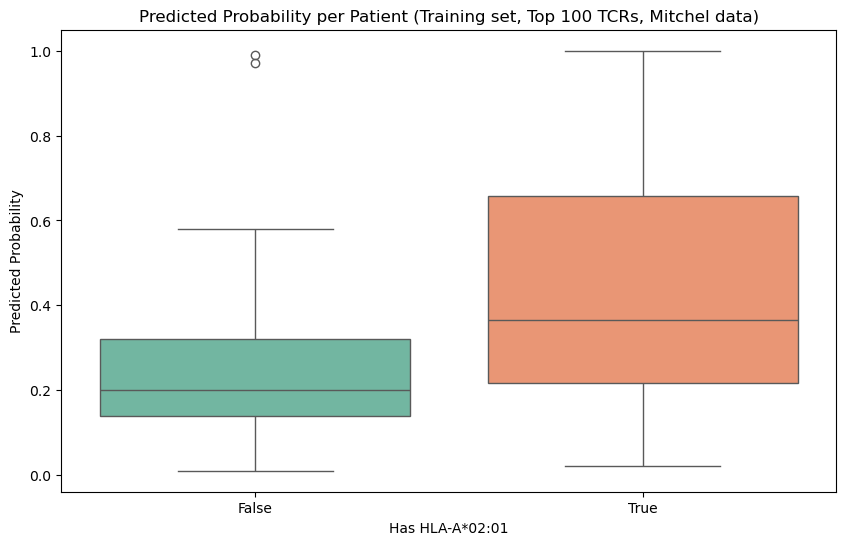

In [49]:
af.plot_box_plot(result_df_mitchel, 100)

In [50]:
result_df_mitchel['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True     108
False    108
Name: count, dtype: int64

In [51]:
result_df_mitchel['prediction'].value_counts()

prediction
0    172
1     44
Name: count, dtype: int64

In [52]:
average_probability = result_df_mitchel['probability'].mean()
average_probability

0.34268518518518515

In [53]:
median_probability = result_df_mitchel['probability'].median()
median_probability

0.26

In [54]:
#calculate accuracy, sensitivity and specificity
# True labels are 'has_HLA_A02_01', predicted label is 'prediction'
result_df_mitchel['has_HLA_A02_01'] =result_df_mitchel['has_HLA_A02_01'].replace('None', np.nan)

#drop none values
result_df_mitchel = result_df_mitchel.dropna()
result_df_mitchel['has_HLA_A02_01_label'] = result_df_mitchel['has_HLA_A02_01'].astype('category').cat.codes

af.calculate_metrics(result_df_mitchel)


Sensitivity: 0.34
Specificity: 0.94
Accuracy: 0.64
              precision    recall  f1-score   support

     Class 0       0.59      0.94      0.72       108
     Class 1       0.84      0.34      0.49       108

    accuracy                           0.64       216
   macro avg       0.71      0.64      0.60       216
weighted avg       0.71      0.64      0.60       216



C:\Users\fried\AppData\Local\Temp\ipykernel_26536\1279340267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_mitchel['has_HLA_A02_01'] =result_df_mitchel['has_HLA_A02_01'].replace('None', np.nan)


(0.3425925925925926, 0.9351851851851852, 0.6388888888888888)

In [55]:
result_df_mitchel[result_df_mitchel['probability'] >= 0.8]['has_HLA_A02_01'].value_counts()

has_HLA_A02_01
True     20
False     2
Name: count, dtype: int64

In [56]:
result_df_mitchel_filtered = result_df_mitchel[(result_df_mitchel['probability'] >= 0.8)]

In [58]:
train_result_df = result_df_mitchel_filtered[['repertoire_id', 'total_tcrs', 'related_tcrs','prediction']]
train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)

C:\Users\fried\AppData\Local\Temp\ipykernel_26536\473128778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result_df.rename(columns={'prediction': 'has_HLA_A02_01_label'}, inplace=True)


Before removing duplicates:  7725058
After removing duplicates:  6792082
Related TCRs fisher exact:  64976
Selected related TCRs:  100
Training set:  49
has_HLA_A02_01_label
0    25
1    24
Name: count, dtype: int64
Training set:  71
has_HLA_A02_01_label
1    46
0    25
Name: count, dtype: int64
ROC Logistic Regression top 100 related tcrs (Training set), Semi-supervised, Convergence method, Sorted by p-value


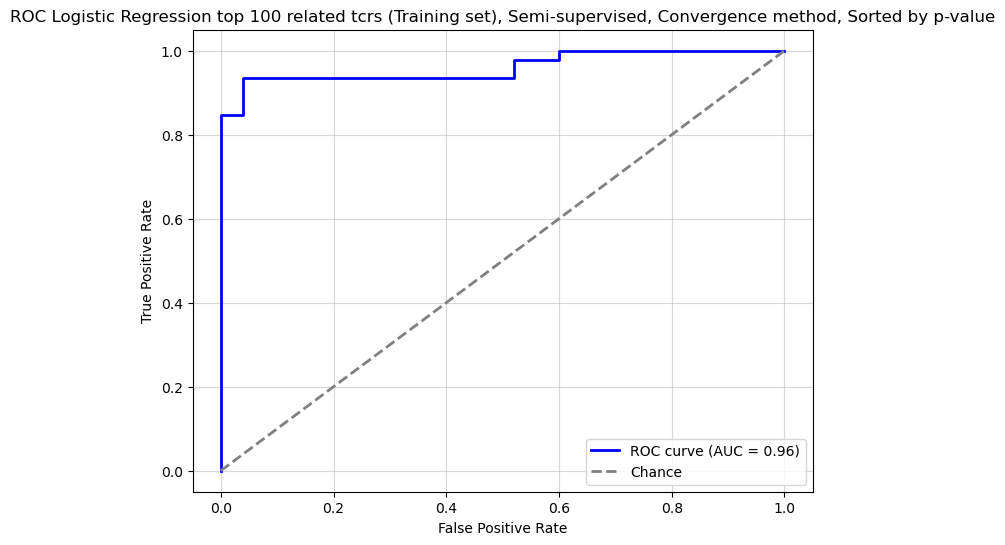

Sensitivity: 0.93
Specificity: 0.96
Accuracy: 0.94
              precision    recall  f1-score   support

     Class 0       0.89      0.96      0.92        25
     Class 1       0.98      0.93      0.96        46

    accuracy                           0.94        71
   macro avg       0.93      0.95      0.94        71
weighted avg       0.95      0.94      0.94        71

Related TCRs fisher exact:  64976
Selected related TCRs:  100
ROC Logistic Regression top 100 related tcrs (Validation set), Convergence method, Sorted by p-value


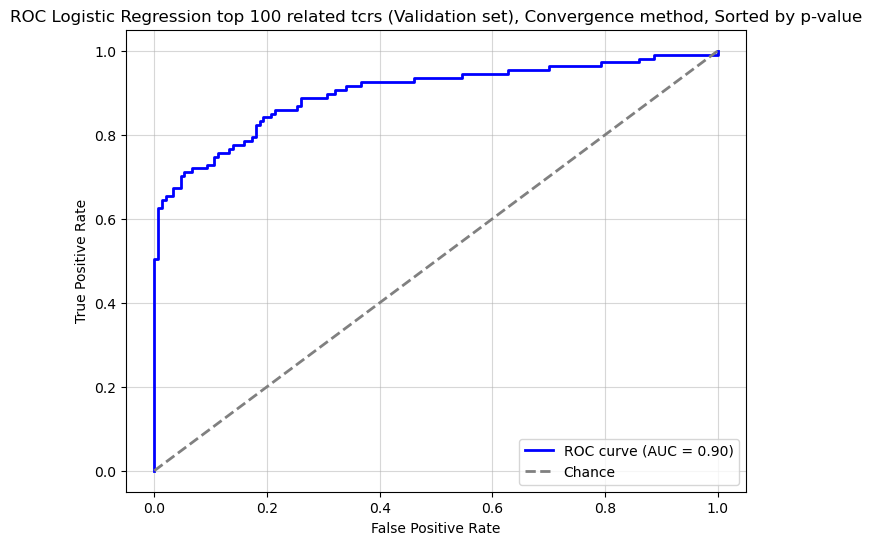

Sensitivity: 0.68
Specificity: 0.95
Accuracy: 0.84
              precision    recall  f1-score   support

     Class 0       0.81      0.95      0.87       150
     Class 1       0.91      0.68      0.78       107

    accuracy                           0.84       257
   macro avg       0.86      0.82      0.83       257
weighted avg       0.85      0.84      0.84       257



,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,sort_column,roc_auc,sensitivity,specificity,accuracy
0,100,None,None,False,p_value,0.899003,0.682243,0.953333,0.840467


In [59]:
metrics_validation_data = []
metrics_training_data = []

bn = False
n = 100


patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\A_02_01_features.txt')
patient_df_training = af.select_patients_hla_labelling(patient_df, number_of_patients=50)
patient_df_validation = af.select_patients_hla_labelling(patient_df, 400, training=False)


convergence_results_df = af.read_file('results\\8\\convergence_results.tsv')
#remomve duplicate rows: where v_call, j_call, junction_aa and convergence are the same
print("Before removing duplicates: ", len(convergence_results_df))
convergence_results_df = convergence_results_df.drop_duplicates(subset=['v_call', 'j_call', 'junction_aa', 'convergence'], keep='first', ignore_index=True)
print("After removing duplicates: ", len(convergence_results_df))
convergence_results_df.rename(columns={'pvalue': 'p_value', 'convergence': 'odds_ratio'}, inplace=True)
#v_call currently is in the format TRBV7-2*01, we want to split this into, TRBV7-2 and 01 and olny keep the first part
convergence_results_df['v_call'] = convergence_results_df['v_call'].apply(lambda x: x.split('*')[0])
patients_path = '\\data\\HLA_emerson_2017'


result_df_emerson = af.preprocessing_dataset(convergence_results_df, patient_df_training, patients_path, top_n=n, benjamini_hochberg=bn)


#training set
#select first 400 patients for training
result_df_training = result_df_emerson.iloc[:400]
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())
result_df_training = pd.concat([train_result_df, result_df_training], ignore_index=True)
print("Training set: ", len(result_df_training))
print(result_df_training['has_HLA_A02_01_label'].value_counts())

filename = 'results\\models\\logistic_regression_semi_supervised_training_convergence.joblib'
model, metrics_training = af.train_training_dataset(result_df_training, top_n=n, benjamini_hochberg=bn, convergence_method=True, folder='results\\9',
                                                     filename_model=filename, semi_supervised=True)
metrics_training_data.append(metrics_training)

#validation set
result_df_validation = af.preprocessing_dataset(convergence_results_df, patient_df_validation, patients_path, top_n=n, benjamini_hochberg=bn)
metrics_validation = af.validate_validation_dataset(result_df_validation, top_n=n, benjamini_hochberg=bn, 
                                                    model=model, convergence_method=True, folder='results\\8')
metrics_validation_data.append(metrics_validation)


metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_semi_supervised_convergence.tsv')
af.write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_semi_supervised_convergence.tsv')

metrics_training_df
metrics_validation_df

In [60]:
metrics_validation_dff = pd.DataFrame(af.read_file('results\\8\\metrics_classifiers_validation_convergence_method.tsv'))
metrics_validation_dff.iloc[:, 0] = metrics_validation_dff.iloc[:, 0].apply(ast.literal_eval)

# Now expand the dictionary
metrics_validation_dff = metrics_validation_dff.iloc[:, 0].apply(pd.Series)
#metrics_validation_df_expanded = metrics_validation_df.iloc[:, 0].apply(pd.Series)
metrics_validation_dff

,top_n,threshold,selected_tcrs_patients,benjamini_hochberg,roc_auc,sensitivity,specificity,accuracy
0,5,None,None,False,0.491713,0.000000,1.000000,0.583658
1,10,None,None,False,0.491713,0.000000,1.000000,0.583658
2,20,None,None,False,0.491713,0.000000,1.000000,0.583658
3,30,None,None,False,0.923863,0.700935,0.986667,0.867704
4,50,None,None,False,0.906231,0.691589,0.986667,0.863813
5,90,None,None,False,0.895701,0.672897,0.966667,0.844358
6,100,None,None,False,0.893769,0.682243,0.953333,0.840467
7,500,None,None,False,0.953209,0.869159,0.926667,0.902724
8,1000,None,None,False,0.879003,0.570093,0.973333,0.805447


### 9. Do the analysis for allel B*27:05, which is less common

In [32]:
importlib.reload(af)

<module 'analysis_functions' from 'c:\\Users\\fried\\Desktop\\Project_emerson\\analysis_functions.py'>

In [3]:
tcr_df = af.read_file('results\\tcr_df_output.tsv')
tcr_df['repertoire_ids'] = tcr_df['repertoire_ids'].apply(ast.literal_eval)

In [23]:
patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\B_27_05_features.txt', hla_type='HLA-B*27:05')
patient_df = af.select_patients_hla_labelling(patient_df, number_of_patients=400, hla_column='has_HLA_B27_05')

patient_df

,repertoire_id,has_HLA_B27_05
0,P00001_clonotypes,False
1,P00002_clonotypes,True
2,P00003_clonotypes,False
3,P00004_clonotypes,False
4,P00005_clonotypes,False
...,...,...
367,P00397_clonotypes,False
368,P00398_clonotypes,False
369,P00399_clonotypes,False
370,P00400_clonotypes,False


In [24]:
patient_df['has_HLA_B27_05'].value_counts()

has_HLA_B27_05
False    348
True      24
Name: count, dtype: int64

In [26]:
fisher_exact_results_df_hla_b = af.execute_fisher_exact(tcr_df, patient_df, hla_column='has_HLA_B27_05', hla_type='HLA-B*27:05')


c:\Users\fried\miniconda3\envs\env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'fisher_exact_results_df' is not defined

In [27]:
af.write_to_file(fisher_exact_results_df_hla_b, 'results\\fisher_exact_results_b_27_05.tsv')

In [28]:
related_tcrs_hla_b = fisher_exact_results_df_hla_b[(fisher_exact_results_df_hla_b['p_value'] < 0.05) & (fisher_exact_results_df_hla_b['odds_ratio'] > 1)].reset_index(drop=True)
print("Related TCRs fisher exact: ",len(related_tcrs_hla_b))

Related TCRs fisher exact:  18262


Related TCRs fisher exact:  18262
Selected related TCRs:  5


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 5 related tcrs (Training set), Sorted by p-value


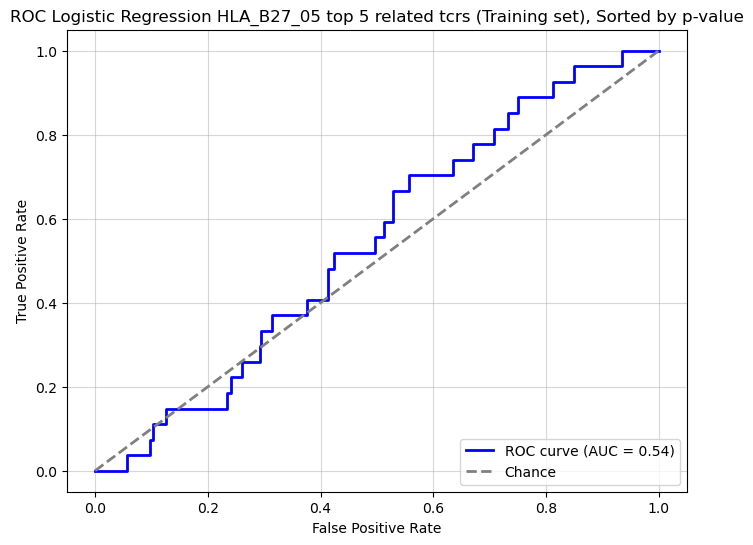

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.93
              precision    recall  f1-score   support

     Class 0       0.93      1.00      0.97       373
     Class 1       0.00      0.00      0.00        27

    accuracy                           0.93       400
   macro avg       0.47      0.50      0.48       400
weighted avg       0.87      0.93      0.90       400

ROC Logistic Regression HLA_B27_05 top 5 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

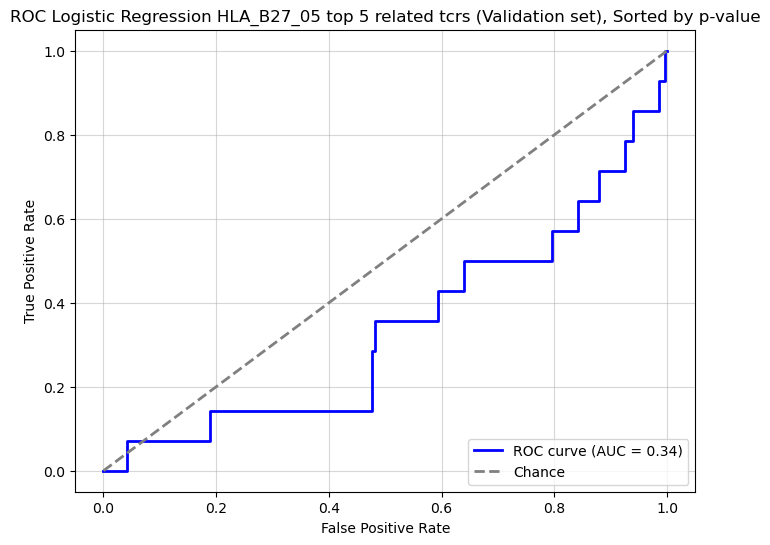

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.94
              precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97       216
     Class 1       0.00      0.00      0.00        14

    accuracy                           0.94       230
   macro avg       0.47      0.50      0.48       230
weighted avg       0.88      0.94      0.91       230

Related TCRs fisher exact:  18262
Selected related TCRs:  10


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

ROC Logistic Regression HLA_B27_05 top 10 related tcrs (Training set), Sorted by p-value


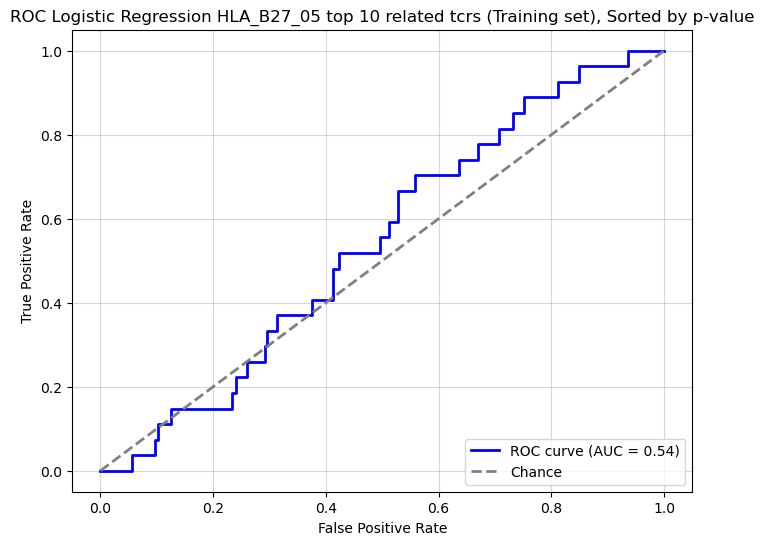

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.93
              precision    recall  f1-score   support

     Class 0       0.93      1.00      0.97       373
     Class 1       0.00      0.00      0.00        27

    accuracy                           0.93       400
   macro avg       0.47      0.50      0.48       400
weighted avg       0.87      0.93      0.90       400

ROC Logistic Regression HLA_B27_05 top 10 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

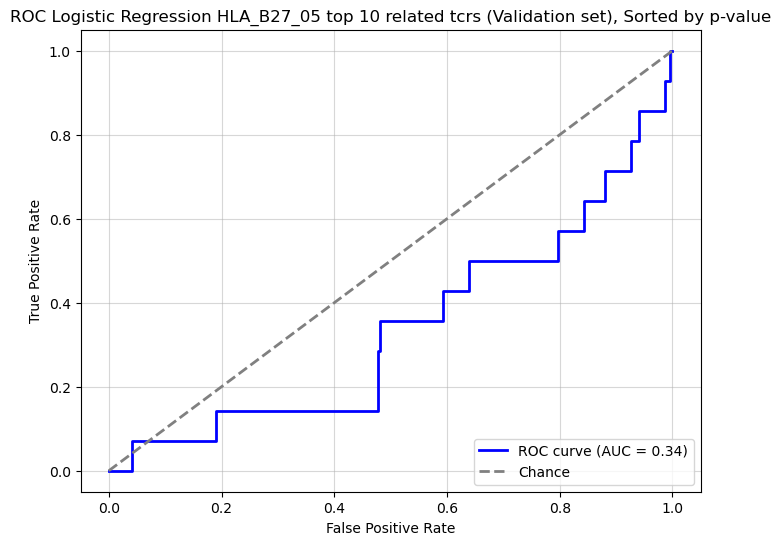

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.94
              precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97       216
     Class 1       0.00      0.00      0.00        14

    accuracy                           0.94       230
   macro avg       0.47      0.50      0.48       230
weighted avg       0.88      0.94      0.91       230

Related TCRs fisher exact:  18262
Selected related TCRs:  20


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

ROC Logistic Regression HLA_B27_05 top 20 related tcrs (Training set), Sorted by p-value


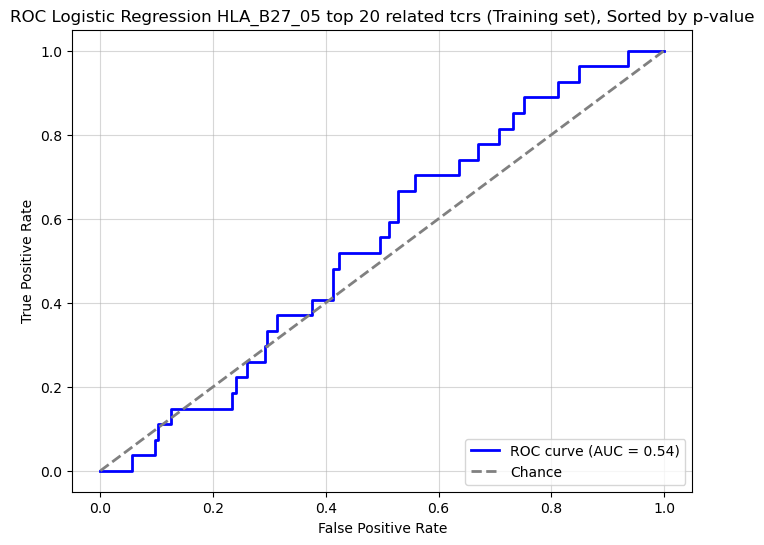

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.93
              precision    recall  f1-score   support

     Class 0       0.93      1.00      0.97       373
     Class 1       0.00      0.00      0.00        27

    accuracy                           0.93       400
   macro avg       0.47      0.50      0.48       400
weighted avg       0.87      0.93      0.90       400

ROC Logistic Regression HLA_B27_05 top 20 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

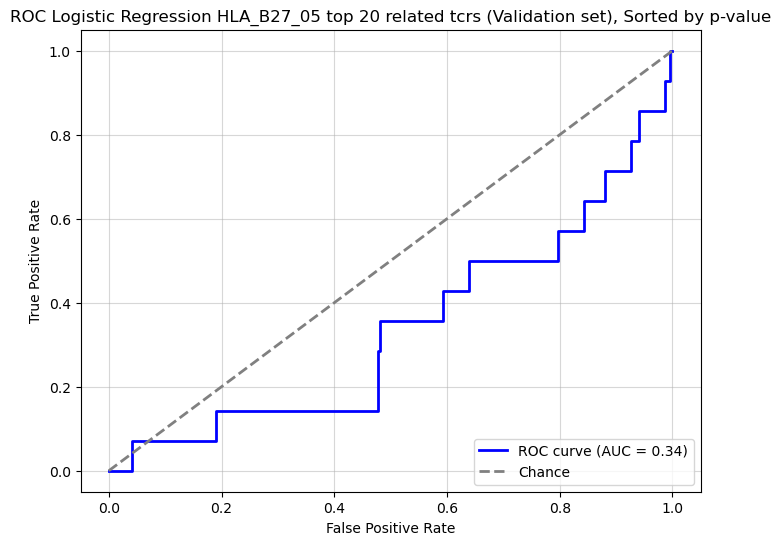

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.94
              precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97       216
     Class 1       0.00      0.00      0.00        14

    accuracy                           0.94       230
   macro avg       0.47      0.50      0.48       230
weighted avg       0.88      0.94      0.91       230

Related TCRs fisher exact:  18262
Selected related TCRs:  30


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

ROC Logistic Regression HLA_B27_05 top 30 related tcrs (Training set), Sorted by p-value


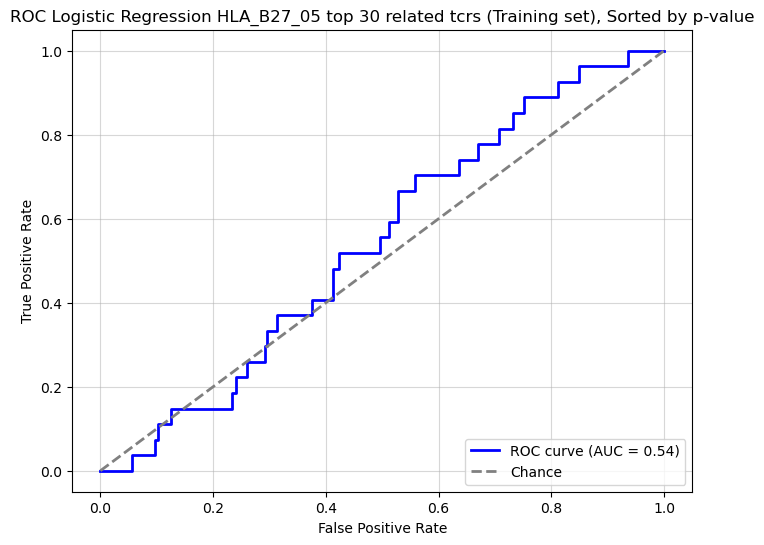

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.93
              precision    recall  f1-score   support

     Class 0       0.93      1.00      0.97       373
     Class 1       0.00      0.00      0.00        27

    accuracy                           0.93       400
   macro avg       0.47      0.50      0.48       400
weighted avg       0.87      0.93      0.90       400

ROC Logistic Regression HLA_B27_05 top 30 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

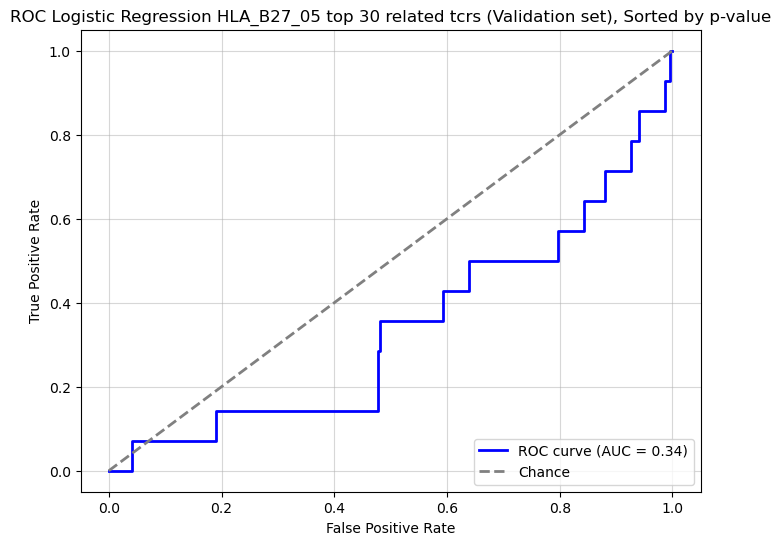

Sensitivity: 0.00
Specificity: 1.00
Accuracy: 0.94
              precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97       216
     Class 1       0.00      0.00      0.00        14

    accuracy                           0.94       230
   macro avg       0.47      0.50      0.48       230
weighted avg       0.88      0.94      0.91       230

Related TCRs fisher exact:  18262
Selected related TCRs:  50


c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\miniconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fried\Desktop\Pr

ROC Logistic Regression HLA_B27_05 top 50 related tcrs (Training set), Sorted by p-value


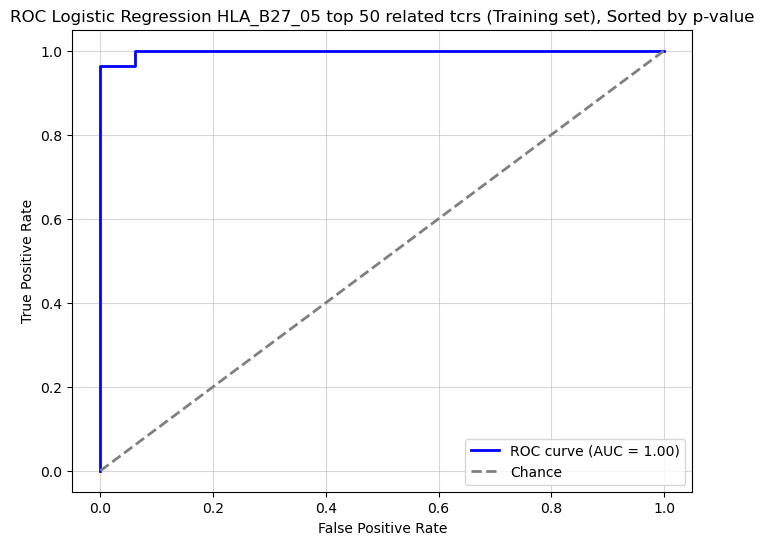

Sensitivity: 0.96
Specificity: 1.00
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       373
     Class 1       0.96      0.96      0.96        27

    accuracy                           0.99       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.99      0.99      0.99       400

ROC Logistic Regression HLA_B27_05 top 50 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


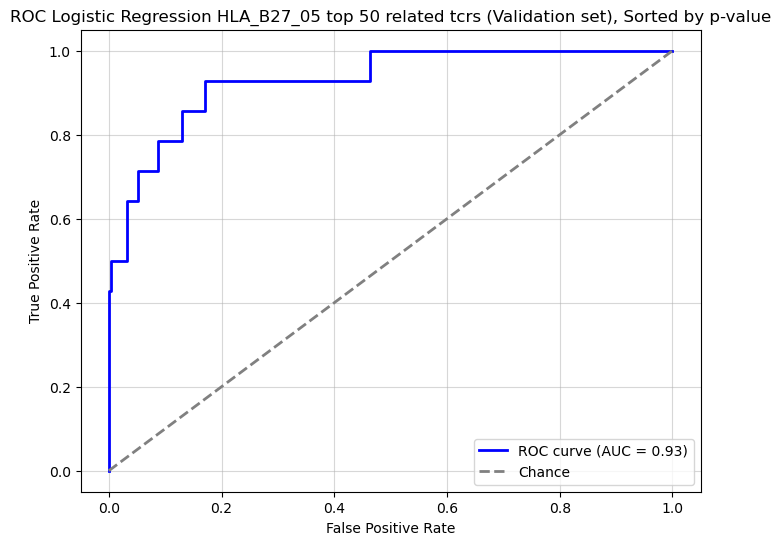

Sensitivity: 0.43
Specificity: 1.00
Accuracy: 0.96
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       216
     Class 1       0.86      0.43      0.57        14

    accuracy                           0.96       230
   macro avg       0.91      0.71      0.78       230
weighted avg       0.96      0.96      0.95       230

Related TCRs fisher exact:  18262
Selected related TCRs:  90


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 90 related tcrs (Training set), Sorted by p-value


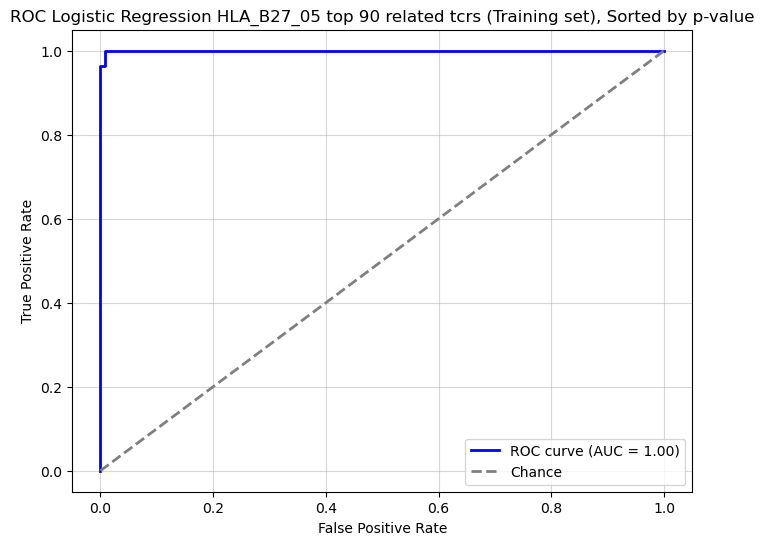

Sensitivity: 0.96
Specificity: 1.00
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       373
     Class 1       0.96      0.96      0.96        27

    accuracy                           0.99       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.99      0.99      0.99       400

ROC Logistic Regression HLA_B27_05 top 90 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


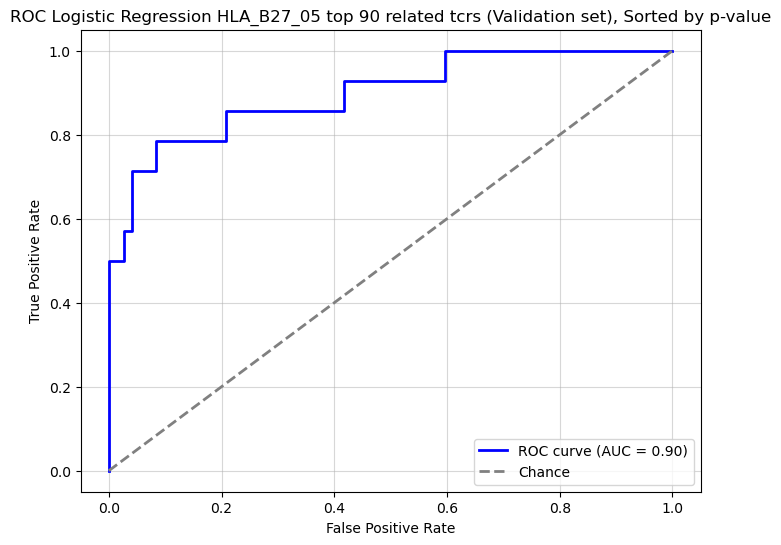

Sensitivity: 0.50
Specificity: 1.00
Accuracy: 0.97
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98       216
     Class 1       1.00      0.50      0.67        14

    accuracy                           0.97       230
   macro avg       0.98      0.75      0.83       230
weighted avg       0.97      0.97      0.96       230

Related TCRs fisher exact:  18262
Selected related TCRs:  100


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 100 related tcrs (Training set), Sorted by p-value


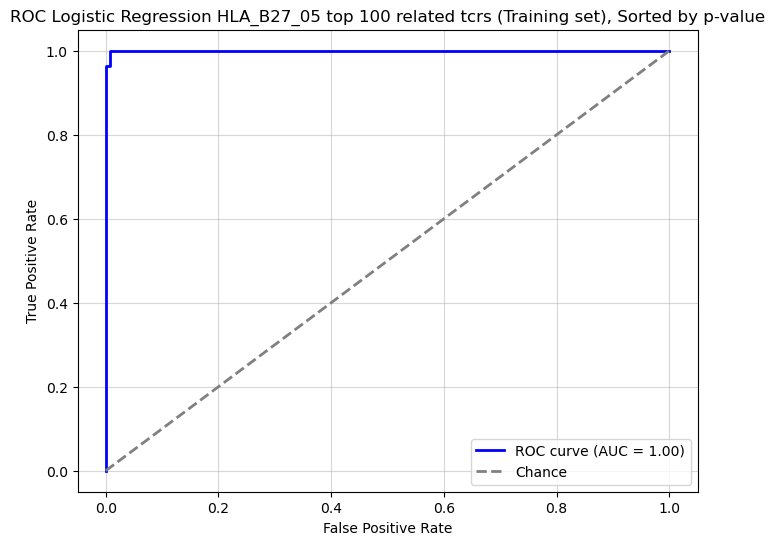

Sensitivity: 0.96
Specificity: 1.00
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       373
     Class 1       0.96      0.96      0.96        27

    accuracy                           0.99       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.99      0.99      0.99       400

ROC Logistic Regression HLA_B27_05 top 100 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


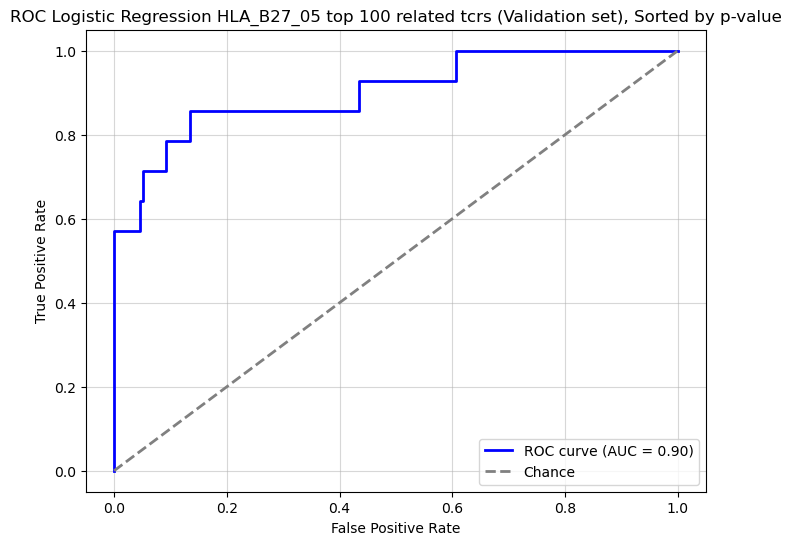

Sensitivity: 0.43
Specificity: 1.00
Accuracy: 0.97
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98       216
     Class 1       1.00      0.43      0.60        14

    accuracy                           0.97       230
   macro avg       0.98      0.71      0.79       230
weighted avg       0.97      0.97      0.96       230

Related TCRs fisher exact:  18262
Selected related TCRs:  500


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 500 related tcrs (Training set), Sorted by p-value


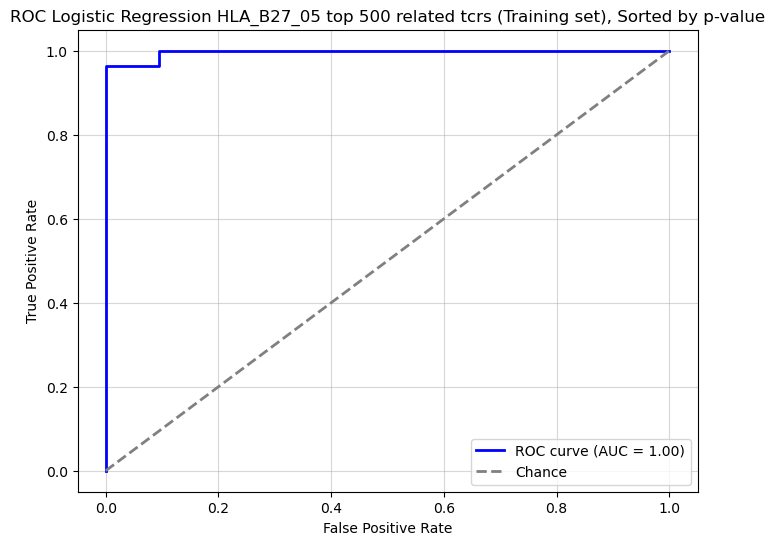

Sensitivity: 0.96
Specificity: 1.00
Accuracy: 1.00
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       373
     Class 1       1.00      0.96      0.98        27

    accuracy                           1.00       400
   macro avg       1.00      0.98      0.99       400
weighted avg       1.00      1.00      1.00       400

ROC Logistic Regression HLA_B27_05 top 500 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


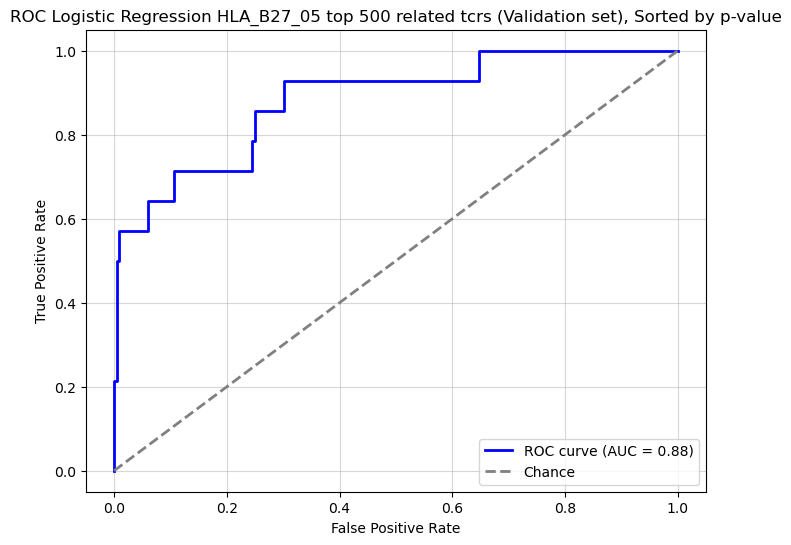

Sensitivity: 0.57
Specificity: 0.99
Accuracy: 0.96
              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98       216
     Class 1       0.73      0.57      0.64        14

    accuracy                           0.96       230
   macro avg       0.85      0.78      0.81       230
weighted avg       0.96      0.96      0.96       230

Related TCRs fisher exact:  18262
Selected related TCRs:  1000


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 1000 related tcrs (Training set), Sorted by p-value


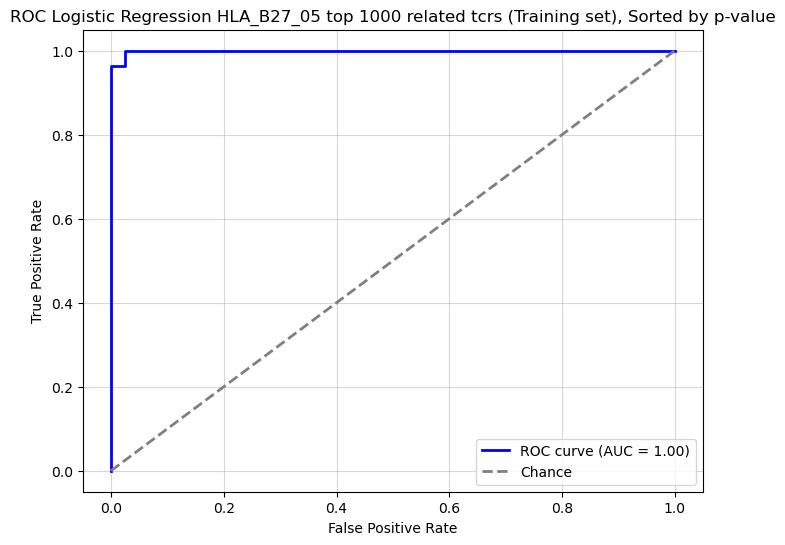

Sensitivity: 0.96
Specificity: 1.00
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       373
     Class 1       0.96      0.96      0.96        27

    accuracy                           0.99       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.99      0.99      0.99       400

ROC Logistic Regression HLA_B27_05 top 1000 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


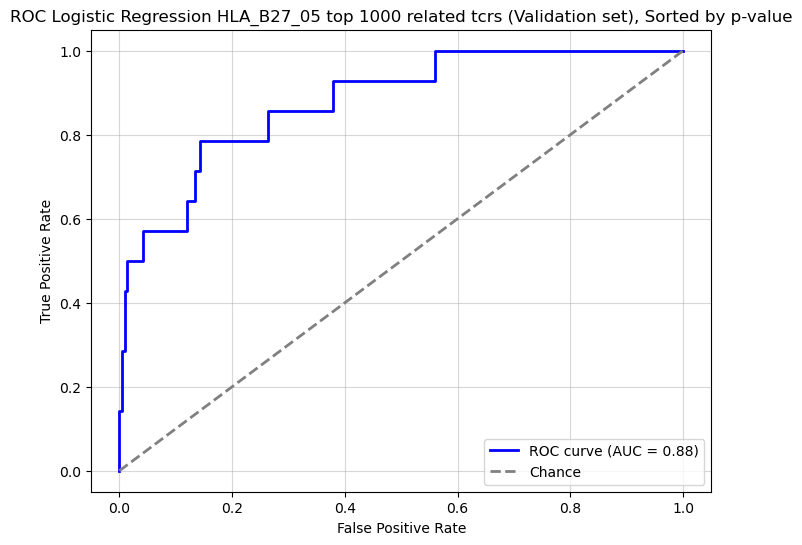

Sensitivity: 0.57
Specificity: 0.95
Accuracy: 0.93
              precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96       216
     Class 1       0.42      0.57      0.48        14

    accuracy                           0.93       230
   macro avg       0.70      0.76      0.72       230
weighted avg       0.94      0.93      0.93       230

Related TCRs fisher exact:  18262
Selected related TCRs:  5000


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 5000 related tcrs (Training set), Sorted by p-value


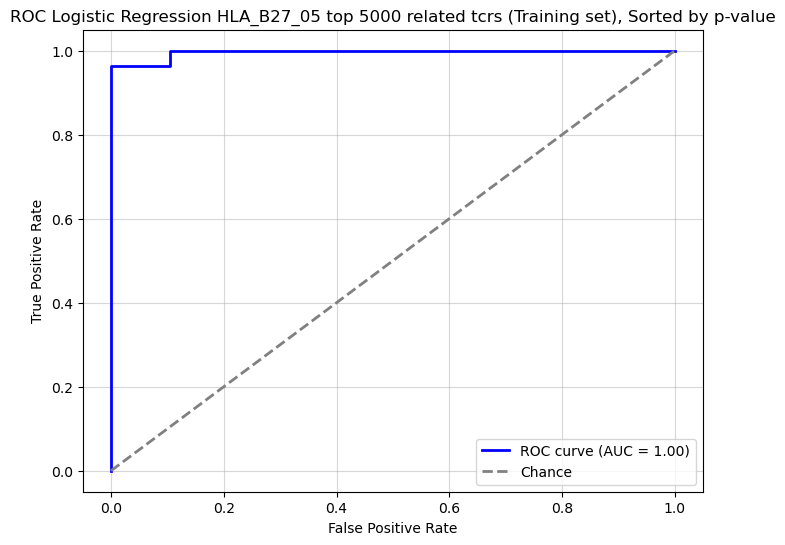

Sensitivity: 0.96
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       373
     Class 1       0.90      0.96      0.93        27

    accuracy                           0.99       400
   macro avg       0.95      0.98      0.96       400
weighted avg       0.99      0.99      0.99       400

ROC Logistic Regression HLA_B27_05 top 5000 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


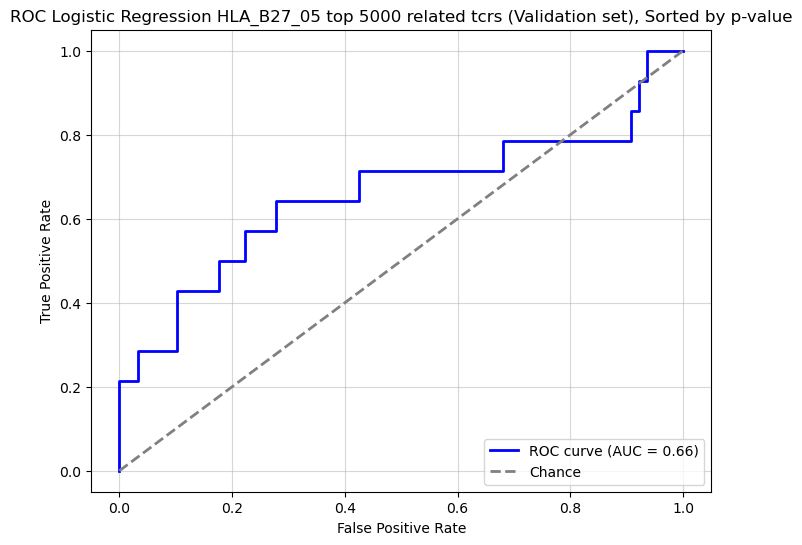

Sensitivity: 0.21
Specificity: 0.98
Accuracy: 0.93
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96       216
     Class 1       0.38      0.21      0.27        14

    accuracy                           0.93       230
   macro avg       0.66      0.60      0.62       230
weighted avg       0.92      0.93      0.92       230

Related TCRs fisher exact:  18262
Selected related TCRs:  10000


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['probability'] = model.predict_proba(X)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['prediction'] = model.predict(X)


ROC Logistic Regression HLA_B27_05 top 10000 related tcrs (Training set), Sorted by p-value


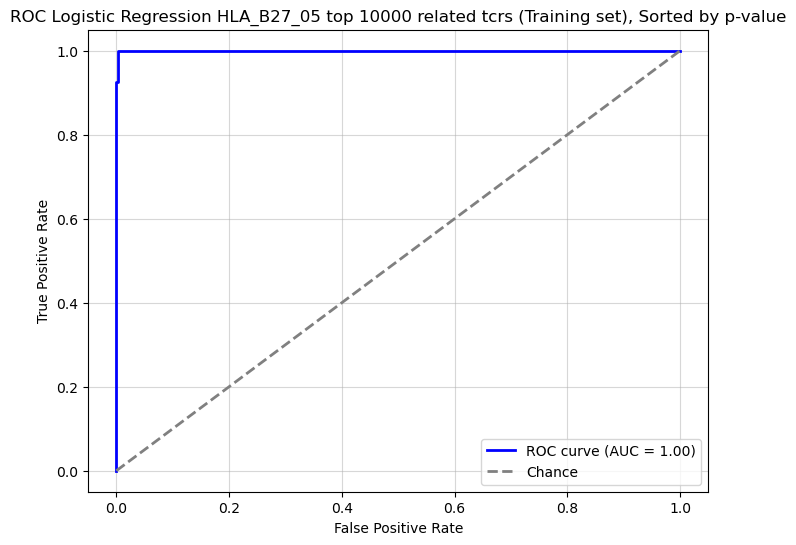

Sensitivity: 1.00
Specificity: 0.99
Accuracy: 0.99
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       373
     Class 1       0.93      1.00      0.96        27

    accuracy                           0.99       400
   macro avg       0.97      1.00      0.98       400
weighted avg       1.00      0.99      1.00       400

ROC Logistic Regression HLA_B27_05 top 10000 related tcrs (Validation set), Sorted by p-value


c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['probability'] = model.predict_proba(X_val)[:, 1]
c:\Users\fried\Desktop\Project_emerson\analysis_functions.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_validation['prediction'] = model.predict(X_val)


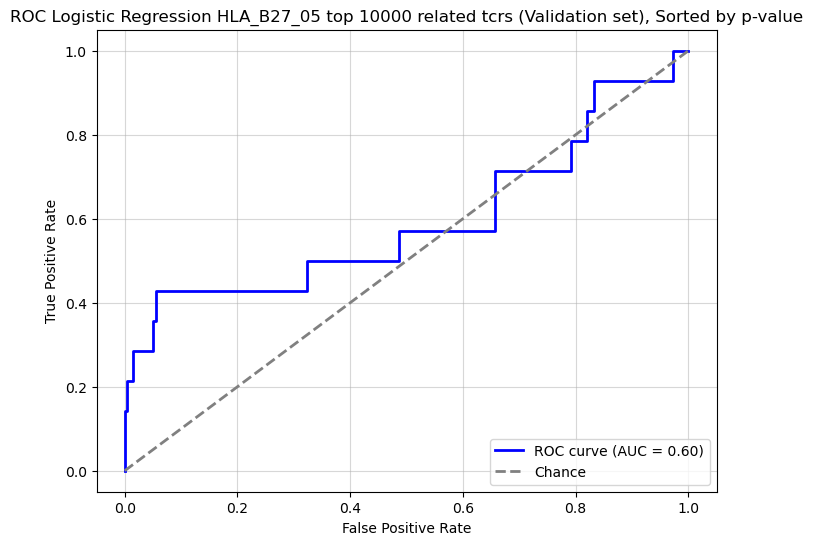

Sensitivity: 0.43
Specificity: 0.90
Accuracy: 0.87
              precision    recall  f1-score   support

     Class 0       0.96      0.90      0.93       216
     Class 1       0.22      0.43      0.29        14

    accuracy                           0.87       230
   macro avg       0.59      0.67      0.61       230
weighted avg       0.92      0.87      0.89       230

Related TCRs fisher exact:  18262
Selected related TCRs:  18262


TypeError: tuple indices must be integers or slices, not str

In [ ]:
top_n = [5, 10, 20, 30, 50, 90, 100, 500, 1000, 5000, 10000]


metrics_training_data = []
metrics_validation_data = []

patient_df = af.match_hla('\\data\\HLA_emerson_2017', '\\data\\B_27_05_features.txt', hla_type='HLA-B*27:05')
patient_df = af.select_patients_hla_labelling(patient_df, hla_column='has_HLA_B27_05')

fisher_exact_results_df = af.read_file('results\\fisher_exact_results_b_27_05.tsv')
fisher_exact_results_df['TCR'] = fisher_exact_results_df['TCR'].apply(ast.literal_eval)
patients_path = '\\data\\HLA_emerson_2017'

bn = False

for n in top_n:
    #result_df_training_plot = result_df_copy.iloc[:400]
    #af.plot_total_vs_significant_tcrs(result_df_training_plot, n)
    result_df = af.preprocessing_dataset(fisher_exact_results_df, patient_df, patients_path, top_n=n, benjamini_hochberg=bn, hla_column='has_HLA_B27_05')
    filename = 'results\\models\\logistic_regression_top' + str(n) + '_fisher_exact_hla_b_27_05.joblib'
    model, metrics_training = af.train_training_dataset(result_df, top_n=n, benjamini_hochberg=bn,
                                                         filename_model=filename, folder='results\\9', hla_column='has_HLA_B27_05')
    metrics_training_data.append(metrics_training)

    #validation set
    metrics_validation = af.validate_validation_dataset(result_df, top_n=n, number_patients=400,
                                                        benjamini_hochberg=bn, model=model, folder='results\\9', hla_column='has_HLA_B27_05')
    metrics_validation_data.append(metrics_validation)

    
metrics_training_df = pd.DataFrame(metrics_training_data)
metrics_validation_df = pd.DataFrame(metrics_validation_data)

af.write_to_file(metrics_training_df, 'results\\metrics_classifiers_training_hla_b_27_05.tsv')
af.write_to_file(metrics_validation_df, 'results\\metrics_classifiers_validation_hla_b_27_05.tsv')

metrics_training_df
metrics_validation_df